In [1]:
# Name: Jinwei Hu
# Username: ACSE-jh4322

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()
import shap

# Load data and data preprocessing

In [2]:
# read csv
dataset = pd.read_csv('data/updated_coalescence.csv')

# use min-max normalization
scaler = preprocessing.MinMaxScaler()

# split data and label
data = dataset.iloc[:, :5]
data

,D/W 1,D/W 2,"dt, ms",flow,Heff
0,0.439492,0.444841,165,14.0,161
1,0.427011,0.455538,270,14.0,161
2,0.473368,0.444841,265,14.0,161
3,0.480499,0.433252,236,14.0,161
4,0.472476,0.436817,94,14.0,161
...,...,...,...,...,...
1496,0.461569,0.480358,309,20.0,154
1497,0.487384,0.499938,103,20.0,154
1498,0.457170,0.582460,66,20.0,154
1499,0.507087,0.486507,318,20.0,154


In [3]:
# preprocess D/W 1 and D/W 2
data['D/W 1 + D/W 2'] = data['D/W 1'] + data['D/W 2']
data['|D/W 1 - D/W 2|'] = abs(data['D/W 1'] - data['D/W 2'])
data

,D/W 1,D/W 2,"dt, ms",flow,Heff,D/W 1 + D/W 2,|D/W 1 - D/W 2|
0,0.439492,0.444841,165,14.0,161,0.884333,0.005349
1,0.427011,0.455538,270,14.0,161,0.882550,0.028527
2,0.473368,0.444841,265,14.0,161,0.918208,0.028527
3,0.480499,0.433252,236,14.0,161,0.913751,0.047248
4,0.472476,0.436817,94,14.0,161,0.909294,0.035659
...,...,...,...,...,...,...,...
1496,0.461569,0.480358,309,20.0,154,0.941928,0.018789
1497,0.487384,0.499938,103,20.0,154,0.987322,0.012555
1498,0.457170,0.582460,66,20.0,154,1.039629,0.125290
1499,0.507087,0.486507,318,20.0,154,0.993594,0.020581


In [4]:
# get data
data = data.iloc[:, 2:]
# data = data.iloc[:, [2, 3, 6]]
data

,"dt, ms",flow,Heff,D/W 1 + D/W 2,|D/W 1 - D/W 2|
0,165,14.0,161,0.884333,0.005349
1,270,14.0,161,0.882550,0.028527
2,265,14.0,161,0.918208,0.028527
3,236,14.0,161,0.913751,0.047248
4,94,14.0,161,0.909294,0.035659
...,...,...,...,...,...
1496,309,20.0,154,0.941928,0.018789
1497,103,20.0,154,0.987322,0.012555
1498,66,20.0,154,1.039629,0.125290
1499,318,20.0,154,0.993594,0.020581


In [5]:
# min-max normalization
normalized_data = scaler.fit_transform(data)
columns = ['dt', 'flow', 'Heff', 'D/W 1 + D/W 2', '|D/W 1 - D/W 2|']
# convert to dataframe
normalized_data = pd.DataFrame(normalized_data, columns=columns)
normalized_data

,dt,flow,Heff,D/W 1 + D/W 2,|D/W 1 - D/W 2|
0,0.202719,0.076923,0.343284,0.251599,0.024036
1,0.332509,0.076923,0.343284,0.247751,0.128192
2,0.326329,0.076923,0.343284,0.324722,0.128192
3,0.290482,0.076923,0.343284,0.315100,0.212318
4,0.114957,0.076923,0.343284,0.305479,0.160240
...,...,...,...,...,...
1496,0.380717,1.000000,0.291045,0.375921,0.084432
1497,0.126082,1.000000,0.291045,0.473907,0.056418
1498,0.080346,1.000000,0.291045,0.586815,0.563020
1499,0.391842,1.000000,0.291045,0.487446,0.092484


In [6]:
# remove Heff
without_Heff = normalized_data.iloc[:, [0, 1, 3, 4]]
without_Heff

,dt,flow,D/W 1 + D/W 2,|D/W 1 - D/W 2|
0,0.202719,0.076923,0.251599,0.024036
1,0.332509,0.076923,0.247751,0.128192
2,0.326329,0.076923,0.324722,0.128192
3,0.290482,0.076923,0.315100,0.212318
4,0.114957,0.076923,0.305479,0.160240
...,...,...,...,...
1496,0.380717,1.000000,0.375921,0.084432
1497,0.126082,1.000000,0.473907,0.056418
1498,0.080346,1.000000,0.586815,0.563020
1499,0.391842,1.000000,0.487446,0.092484


In [7]:
# remove D/W 1 +D/W 2
without_plus = normalized_data.iloc[:, [0, 1, 2, 4]]
without_plus

,dt,flow,Heff,|D/W 1 - D/W 2|
0,0.202719,0.076923,0.343284,0.024036
1,0.332509,0.076923,0.343284,0.128192
2,0.326329,0.076923,0.343284,0.128192
3,0.290482,0.076923,0.343284,0.212318
4,0.114957,0.076923,0.343284,0.160240
...,...,...,...,...
1496,0.380717,1.000000,0.291045,0.084432
1497,0.126082,1.000000,0.291045,0.056418
1498,0.080346,1.000000,0.291045,0.563020
1499,0.391842,1.000000,0.291045,0.092484


In [8]:
# remove flow
without_flow = normalized_data.iloc[:, [0, 2, 3, 4]]
without_flow

,dt,Heff,D/W 1 + D/W 2,|D/W 1 - D/W 2|
0,0.202719,0.343284,0.251599,0.024036
1,0.332509,0.343284,0.247751,0.128192
2,0.326329,0.343284,0.324722,0.128192
3,0.290482,0.343284,0.315100,0.212318
4,0.114957,0.343284,0.305479,0.160240
...,...,...,...,...
1496,0.380717,0.291045,0.375921,0.084432
1497,0.126082,0.291045,0.473907,0.056418
1498,0.080346,0.291045,0.586815,0.563020
1499,0.391842,0.291045,0.487446,0.092484


In [9]:
# remove D/W - D/W 2
without_minus = normalized_data.iloc[:, [0, 1, 2, 3]]
without_minus

,dt,flow,Heff,D/W 1 + D/W 2
0,0.202719,0.076923,0.343284,0.251599
1,0.332509,0.076923,0.343284,0.247751
2,0.326329,0.076923,0.343284,0.324722
3,0.290482,0.076923,0.343284,0.315100
4,0.114957,0.076923,0.343284,0.305479
...,...,...,...,...
1496,0.380717,1.000000,0.291045,0.375921
1497,0.126082,1.000000,0.291045,0.473907
1498,0.080346,1.000000,0.291045,0.586815
1499,0.391842,1.000000,0.291045,0.487446


In [10]:
# remove dt
without_dt = normalized_data.iloc[:, [1, 2, 3, 4]]
without_dt

,flow,Heff,D/W 1 + D/W 2,|D/W 1 - D/W 2|
0,0.076923,0.343284,0.251599,0.024036
1,0.076923,0.343284,0.247751,0.128192
2,0.076923,0.343284,0.324722,0.128192
3,0.076923,0.343284,0.315100,0.212318
4,0.076923,0.343284,0.305479,0.160240
...,...,...,...,...
1496,1.000000,0.291045,0.375921,0.084432
1497,1.000000,0.291045,0.473907,0.056418
1498,1.000000,0.291045,0.586815,0.563020
1499,1.000000,0.291045,0.487446,0.092484


In [11]:
# get label
label = dataset.iloc[:, 5]
# modify label 'Y': 1, 'N': 0
label = label.replace({'Y': 1, 'N': 0, 'y': 1})
label

0       1
1       1
2       1
3       1
4       1
       ..
1496    0
1497    0
1498    0
1499    0
1500    0
Name: Coalescence, Length: 1501, dtype: int64

In [12]:
print(label.value_counts())

Coalescence
1    782
0    719
Name: count, dtype: int64


In [13]:
# split train, valid, test dataset
X_train, X_test, y_train, y_test = train_test_split(without_dt, label, test_size=0.2, random_state=42, shuffle=True, stratify=label)

# check their shape
print("train:", X_train.shape)
# print("valid:", X_valid.shape)
print("test:", X_test.shape)

train: (1200, 4)
test: (301, 4)


In [14]:
# check X_train
X_train

,flow,Heff,D/W 1 + D/W 2,|D/W 1 - D/W 2|
774,0.230769,0.865672,0.251300,0.104606
1078,0.000000,0.044776,0.332906,0.224687
597,1.000000,0.820896,0.229176,0.028697
199,0.384615,0.932836,0.232357,0.272408
888,0.384615,0.776119,0.155983,0.164977
...,...,...,...,...
1460,1.000000,0.291045,0.475662,0.240875
257,0.692308,0.701493,0.230530,0.275147
835,0.384615,0.776119,0.207438,0.000134
1260,0.076923,0.037313,0.448818,0.295986


In [72]:
# check label distribution in train set
print(y_train.value_counts())

Coalescence
1    625
0    575
Name: count, dtype: int64


In [73]:
# check label distribution in test set
print(y_test.value_counts())

Coalescence
1    157
0    144
Name: count, dtype: int64


# create RF model

In [46]:
rf = RandomForestClassifier(random_state=42, n_estimators=7, max_depth=145)
# train on grid
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=145, n_estimators=7, random_state=42)

In [47]:
# predict on test set
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.74      0.73       144
           1       0.75      0.75      0.75       157

    accuracy                           0.74       301
   macro avg       0.74      0.74      0.74       301
weighted avg       0.74      0.74      0.74       301



In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7408637873754153

In [67]:
precision = precision_score(y_test, y_pred)
precision

0.7354838709677419

In [68]:
recall = recall_score(y_test, y_pred)
recall

0.7261146496815286

In [22]:
f1 = f1_score(y_test, y_pred)
f1

0.7096774193548387

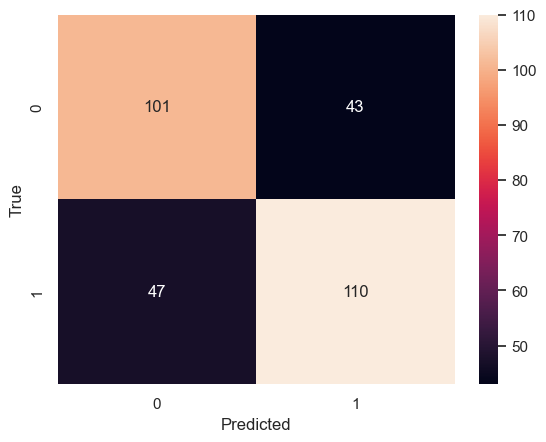

In [23]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Variable Importance Plot - Global Interpretation


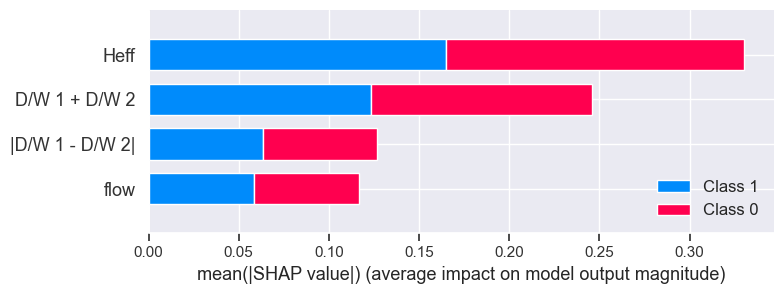

In [24]:
# load JS visualization code to notebook
shap.initjs()

# Create the explainer
# explainer = shap.TreeExplainer(best_rf)
explainer = shap.TreeExplainer(rf)

"""
Compute shap_values for all of X_test rather instead of
a single row, to have more data for plot.
"""
rf_shap_values = explainer.shap_values(X_test)
print("Variable Importance Plot - Global Interpretation")
figure = plt.figure()
shap.summary_plot(rf_shap_values, X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


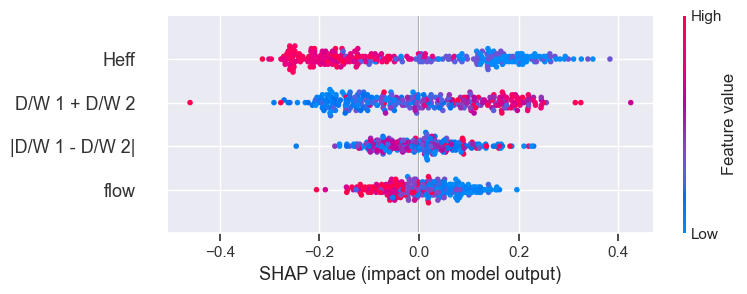

In [25]:
# Summary Plot Deep-Dive on Label 1
shap.summary_plot(rf_shap_values[1], X_test)

In [26]:
sample_index = 11
class_index = 1 
sample_explanation = rf_shap_values[class_index][sample_index]
shap.force_plot(explainer.expected_value[class_index], sample_explanation, X_test.iloc[sample_index,:], link="logit")



In [38]:
print(y_test.iloc[11])

1


# create XGBoost

In [83]:
# split train, valid, test dataset
X_train, X_test, y_train, y_test = train_test_split(without_dt, label, test_size=0.2, random_state=42, shuffle=True, stratify=label)
X_train

,flow,Heff,D/W 1 + D/W 2,|D/W 1 - D/W 2|
774,0.230769,0.865672,0.251300,0.104606
1078,0.000000,0.044776,0.332906,0.224687
597,1.000000,0.820896,0.229176,0.028697
199,0.384615,0.932836,0.232357,0.272408
888,0.384615,0.776119,0.155983,0.164977
...,...,...,...,...
1460,1.000000,0.291045,0.475662,0.240875
257,0.692308,0.701493,0.230530,0.275147
835,0.384615,0.776119,0.207438,0.000134
1260,0.076923,0.037313,0.448818,0.295986


In [84]:
xgb = XGBClassifier(random_state=42, n_estimators=2, max_depth=15)
xgb.fit(X_train, y_train)
# predict on test set
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))
#  calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       144
           1       0.75      0.75      0.75       157

    accuracy                           0.74       301
   macro avg       0.74      0.74      0.74       301
weighted avg       0.74      0.74      0.74       301



0.7408637873754153

# MLP model

In [13]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
import lime
from lime import lime_tabular
import numpy as np
from tensorflow.keras import optimizers
from sklearn.model_selection import StratifiedKFold
def create_model(activation='relu', learning_rates=0.01, dropout_rate=0.1, l2_rate=0.01, optimizer=optimizers.Adam):
    model = Sequential()
    model.add(Dense(256, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_rate), input_shape=(5,)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_rate)))
    model.add(Dense(32, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_rate)))
    model.add(Dense(16, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_rate)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer(learning_rate=learning_rates), metrics=['accuracy'])
    return model

In [13]:
# split train, valid, test dataset
X_train, X_test, y_train, y_test = train_test_split(normalized_data, label, test_size=0.2, random_state=42, shuffle=True, stratify=label)
X_train

,dt,flow,Heff,D/W 1 + D/W 2,|D/W 1 - D/W 2|
774,0.490729,0.230769,0.865672,0.251300,0.104606
1078,0.322621,0.000000,0.044776,0.332906,0.224687
597,0.011125,1.000000,0.820896,0.229176,0.028697
199,0.194067,0.384615,0.932836,0.232357,0.272408
888,0.023486,0.384615,0.776119,0.155983,0.164977
...,...,...,...,...,...
1460,0.046972,1.000000,0.291045,0.475662,0.240875
257,0.153276,0.692308,0.701493,0.230530,0.275147
835,0.144623,0.384615,0.776119,0.207438,0.000134
1260,0.147095,0.076923,0.037313,0.448818,0.295986


In [14]:
best_model = create_model(activation='relu', learning_rates=0.001, l2_rate=0.01, dropout_rate=0.1, optimizer=optimizers.Adam)
best_model.fit(X_train, y_train, epochs=2500)

# test on best model
_, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_acc}')

Epoch 1/2500
38/38 [==============================] - 1s 998us/step - loss: 2.9990 - accuracy: 0.7117
Epoch 2/2500
38/38 [==============================] - 0s 922us/step - loss: 1.6959 - accuracy: 0.7350
Epoch 3/2500
38/38 [==============================] - 0s 930us/step - loss: 1.1108 - accuracy: 0.7467
Epoch 4/2500
38/38 [==============================] - 0s 926us/step - loss: 0.8767 - accuracy: 0.7417
Epoch 5/2500
38/38 [==============================] - 0s 925us/step - loss: 0.7545 - accuracy: 0.7425
Epoch 6/2500
38/38 [==============================] - 0s 922us/step - loss: 0.6959 - accuracy: 0.7325
Epoch 7/2500
38/38 [==============================] - 0s 989us/step - loss: 0.6693 - accuracy: 0.7392
Epoch 8/2500
38/38 [==============================] - 0s 928us/step - loss: 0.6428 - accuracy: 0.7375
Epoch 9/2500
38/38 [==============================] - 0s 923us/step - loss: 0.6295 - accuracy: 0.7383
Epoch 10/2500
38/38 [==============================] - 0s 934us/step - loss: 0.620

Epoch 81/2500
38/38 [==============================] - 0s 978us/step - loss: 0.5649 - accuracy: 0.7442
Epoch 82/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5681 - accuracy: 0.7300
Epoch 83/2500
38/38 [==============================] - 0s 978us/step - loss: 0.5682 - accuracy: 0.7375
Epoch 84/2500
38/38 [==============================] - 0s 949us/step - loss: 0.5662 - accuracy: 0.7425
Epoch 85/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5705 - accuracy: 0.7392
Epoch 86/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5677 - accuracy: 0.7417
Epoch 87/2500
38/38 [==============================] - 0s 962us/step - loss: 0.5712 - accuracy: 0.7333
Epoch 88/2500
38/38 [==============================] - 0s 904us/step - loss: 0.5627 - accuracy: 0.7417
Epoch 89/2500
38/38 [==============================] - 0s 901us/step - loss: 0.5647 - accuracy: 0.7375
Epoch 90/2500
38/38 [==============================] - 0s 889us/step - loss: 0.

38/38 [==============================] - 0s 919us/step - loss: 0.5683 - accuracy: 0.7292
Epoch 161/2500
38/38 [==============================] - 0s 916us/step - loss: 0.5689 - accuracy: 0.7400
Epoch 162/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5614 - accuracy: 0.7458
Epoch 163/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5576 - accuracy: 0.7425
Epoch 164/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5598 - accuracy: 0.7375
Epoch 165/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5644 - accuracy: 0.7392
Epoch 166/2500
38/38 [==============================] - 0s 997us/step - loss: 0.5617 - accuracy: 0.7417
Epoch 167/2500
38/38 [==============================] - 0s 977us/step - loss: 0.5606 - accuracy: 0.7392
Epoch 168/2500
38/38 [==============================] - 0s 923us/step - loss: 0.5691 - accuracy: 0.7367
Epoch 169/2500
38/38 [==============================] - 0s 895us/step - loss: 0.5670 - 

38/38 [==============================] - 0s 1ms/step - loss: 0.5551 - accuracy: 0.7367
Epoch 319/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5546 - accuracy: 0.7467
Epoch 320/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5580 - accuracy: 0.7458
Epoch 321/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5590 - accuracy: 0.7408
Epoch 322/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5511 - accuracy: 0.7442
Epoch 323/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5635 - accuracy: 0.7383
Epoch 324/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5502 - accuracy: 0.7392
Epoch 325/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5565 - accuracy: 0.7383
Epoch 326/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5594 - accuracy: 0.7300
Epoch 327/2500
38/38 [==============================] - 0s 941us/step - loss: 0.5591 - accuracy: 

38/38 [==============================] - 0s 915us/step - loss: 0.5527 - accuracy: 0.7333
Epoch 477/2500
38/38 [==============================] - 0s 875us/step - loss: 0.5586 - accuracy: 0.7358
Epoch 478/2500
38/38 [==============================] - 0s 883us/step - loss: 0.5565 - accuracy: 0.7300
Epoch 479/2500
38/38 [==============================] - 0s 902us/step - loss: 0.5537 - accuracy: 0.7350
Epoch 480/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5541 - accuracy: 0.7342
Epoch 481/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5556 - accuracy: 0.7417
Epoch 482/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5603 - accuracy: 0.7392
Epoch 483/2500
38/38 [==============================] - 0s 930us/step - loss: 0.5557 - accuracy: 0.7367
Epoch 484/2500
38/38 [==============================] - 0s 916us/step - loss: 0.5541 - accuracy: 0.7442
Epoch 485/2500
38/38 [==============================] - 0s 867us/step - loss: 0.5503 

38/38 [==============================] - 0s 934us/step - loss: 0.5461 - accuracy: 0.7383
Epoch 635/2500
38/38 [==============================] - 0s 969us/step - loss: 0.5478 - accuracy: 0.7425
Epoch 636/2500
38/38 [==============================] - 0s 980us/step - loss: 0.5503 - accuracy: 0.7367
Epoch 637/2500
38/38 [==============================] - 0s 887us/step - loss: 0.5524 - accuracy: 0.7417
Epoch 638/2500
38/38 [==============================] - 0s 880us/step - loss: 0.5543 - accuracy: 0.7308
Epoch 639/2500
38/38 [==============================] - 0s 903us/step - loss: 0.5544 - accuracy: 0.7358
Epoch 640/2500
38/38 [==============================] - 0s 897us/step - loss: 0.5516 - accuracy: 0.7375
Epoch 641/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5511 - accuracy: 0.7325
Epoch 642/2500
38/38 [==============================] - 0s 874us/step - loss: 0.5511 - accuracy: 0.7400
Epoch 643/2500
38/38 [==============================] - 0s 881us/step - loss: 0

Epoch 791/2500
38/38 [==============================] - 0s 946us/step - loss: 0.5468 - accuracy: 0.7425
Epoch 792/2500
38/38 [==============================] - 0s 851us/step - loss: 0.5456 - accuracy: 0.7350
Epoch 793/2500
38/38 [==============================] - 0s 858us/step - loss: 0.5492 - accuracy: 0.7325
Epoch 794/2500
38/38 [==============================] - 0s 882us/step - loss: 0.5516 - accuracy: 0.7350
Epoch 795/2500
38/38 [==============================] - 0s 869us/step - loss: 0.5465 - accuracy: 0.7425
Epoch 796/2500
38/38 [==============================] - 0s 875us/step - loss: 0.5487 - accuracy: 0.7433
Epoch 797/2500
38/38 [==============================] - 0s 888us/step - loss: 0.5496 - accuracy: 0.7492
Epoch 798/2500
38/38 [==============================] - 0s 875us/step - loss: 0.5464 - accuracy: 0.7400
Epoch 799/2500
38/38 [==============================] - 0s 901us/step - loss: 0.5501 - accuracy: 0.7317
Epoch 800/2500
38/38 [==============================] - 0s 885us

38/38 [==============================] - 0s 872us/step - loss: 0.5513 - accuracy: 0.7392
Epoch 948/2500
38/38 [==============================] - 0s 873us/step - loss: 0.5456 - accuracy: 0.7333
Epoch 949/2500
38/38 [==============================] - 0s 882us/step - loss: 0.5496 - accuracy: 0.7342
Epoch 950/2500
38/38 [==============================] - 0s 868us/step - loss: 0.5463 - accuracy: 0.7375
Epoch 951/2500
38/38 [==============================] - 0s 862us/step - loss: 0.5453 - accuracy: 0.7458
Epoch 952/2500
38/38 [==============================] - 0s 877us/step - loss: 0.5483 - accuracy: 0.7475
Epoch 953/2500
38/38 [==============================] - 0s 870us/step - loss: 0.5466 - accuracy: 0.7408
Epoch 954/2500
38/38 [==============================] - 0s 887us/step - loss: 0.5425 - accuracy: 0.7333
Epoch 955/2500
38/38 [==============================] - 0s 869us/step - loss: 0.5450 - accuracy: 0.7392
Epoch 956/2500
38/38 [==============================] - 0s 951us/step - loss: 0

38/38 [==============================] - 0s 901us/step - loss: 0.5429 - accuracy: 0.7433
Epoch 1104/2500
38/38 [==============================] - 0s 922us/step - loss: 0.5503 - accuracy: 0.7300
Epoch 1105/2500
38/38 [==============================] - 0s 902us/step - loss: 0.5451 - accuracy: 0.7325
Epoch 1106/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5488 - accuracy: 0.7400
Epoch 1107/2500
38/38 [==============================] - 0s 883us/step - loss: 0.5444 - accuracy: 0.7408
Epoch 1108/2500
38/38 [==============================] - 0s 882us/step - loss: 0.5468 - accuracy: 0.7400
Epoch 1109/2500
38/38 [==============================] - 0s 869us/step - loss: 0.5458 - accuracy: 0.7383
Epoch 1110/2500
38/38 [==============================] - 0s 869us/step - loss: 0.5474 - accuracy: 0.7383
Epoch 1111/2500
38/38 [==============================] - 0s 871us/step - loss: 0.5486 - accuracy: 0.7350
Epoch 1112/2500
38/38 [==============================] - 0s 874us/step 

38/38 [==============================] - 0s 907us/step - loss: 0.5450 - accuracy: 0.7400
Epoch 1260/2500
38/38 [==============================] - 0s 900us/step - loss: 0.5385 - accuracy: 0.7458
Epoch 1261/2500
38/38 [==============================] - 0s 865us/step - loss: 0.5453 - accuracy: 0.7400
Epoch 1262/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5462 - accuracy: 0.7350
Epoch 1263/2500
38/38 [==============================] - 0s 879us/step - loss: 0.5483 - accuracy: 0.7392
Epoch 1264/2500
38/38 [==============================] - 0s 865us/step - loss: 0.5426 - accuracy: 0.7467
Epoch 1265/2500
38/38 [==============================] - 0s 882us/step - loss: 0.5446 - accuracy: 0.7467
Epoch 1266/2500
38/38 [==============================] - 0s 871us/step - loss: 0.5441 - accuracy: 0.7425
Epoch 1267/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5468 - accuracy: 0.7400
Epoch 1268/2500
38/38 [==============================] - 0s 879us/step 

38/38 [==============================] - 0s 890us/step - loss: 0.5402 - accuracy: 0.7342
Epoch 1416/2500
38/38 [==============================] - 0s 927us/step - loss: 0.5388 - accuracy: 0.7433
Epoch 1417/2500
38/38 [==============================] - 0s 873us/step - loss: 0.5478 - accuracy: 0.7358
Epoch 1418/2500
38/38 [==============================] - 0s 849us/step - loss: 0.5416 - accuracy: 0.7367
Epoch 1419/2500
38/38 [==============================] - 0s 896us/step - loss: 0.5488 - accuracy: 0.7317
Epoch 1420/2500
38/38 [==============================] - 0s 871us/step - loss: 0.5471 - accuracy: 0.7433
Epoch 1421/2500
38/38 [==============================] - 0s 893us/step - loss: 0.5448 - accuracy: 0.7400
Epoch 1422/2500
38/38 [==============================] - 0s 896us/step - loss: 0.5415 - accuracy: 0.7417
Epoch 1423/2500
38/38 [==============================] - 0s 860us/step - loss: 0.5451 - accuracy: 0.7458
Epoch 1424/2500
38/38 [==============================] - 0s 858us/step 

38/38 [==============================] - 0s 880us/step - loss: 0.5460 - accuracy: 0.7383
Epoch 1572/2500
38/38 [==============================] - 0s 905us/step - loss: 0.5422 - accuracy: 0.7417
Epoch 1573/2500
38/38 [==============================] - 0s 880us/step - loss: 0.5444 - accuracy: 0.7400
Epoch 1574/2500
38/38 [==============================] - 0s 875us/step - loss: 0.5464 - accuracy: 0.7283
Epoch 1575/2500
38/38 [==============================] - 0s 877us/step - loss: 0.5452 - accuracy: 0.7325
Epoch 1576/2500
38/38 [==============================] - 0s 873us/step - loss: 0.5445 - accuracy: 0.7400
Epoch 1577/2500
38/38 [==============================] - 0s 881us/step - loss: 0.5464 - accuracy: 0.7317
Epoch 1578/2500
38/38 [==============================] - 0s 848us/step - loss: 0.5455 - accuracy: 0.7425
Epoch 1579/2500
38/38 [==============================] - 0s 868us/step - loss: 0.5446 - accuracy: 0.7342
Epoch 1580/2500
38/38 [==============================] - 0s 899us/step 

38/38 [==============================] - 0s 862us/step - loss: 0.5412 - accuracy: 0.7367
Epoch 1728/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5440 - accuracy: 0.7392
Epoch 1729/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5399 - accuracy: 0.7400
Epoch 1730/2500
38/38 [==============================] - 0s 877us/step - loss: 0.5412 - accuracy: 0.7375
Epoch 1731/2500
38/38 [==============================] - 0s 879us/step - loss: 0.5436 - accuracy: 0.7408
Epoch 1732/2500
38/38 [==============================] - 0s 896us/step - loss: 0.5408 - accuracy: 0.7408
Epoch 1733/2500
38/38 [==============================] - 0s 868us/step - loss: 0.5467 - accuracy: 0.7392
Epoch 1734/2500
38/38 [==============================] - 0s 877us/step - loss: 0.5446 - accuracy: 0.7425
Epoch 1735/2500
38/38 [==============================] - 0s 879us/step - loss: 0.5421 - accuracy: 0.7408
Epoch 1736/2500
38/38 [==============================] - 0s 883us/step 

38/38 [==============================] - 0s 895us/step - loss: 0.5397 - accuracy: 0.7475
Epoch 1884/2500
38/38 [==============================] - 0s 895us/step - loss: 0.5563 - accuracy: 0.7308
Epoch 1885/2500
38/38 [==============================] - 0s 870us/step - loss: 0.5439 - accuracy: 0.7450
Epoch 1886/2500
38/38 [==============================] - 0s 887us/step - loss: 0.5479 - accuracy: 0.7358
Epoch 1887/2500
38/38 [==============================] - 0s 864us/step - loss: 0.5471 - accuracy: 0.7350
Epoch 1888/2500
38/38 [==============================] - 0s 903us/step - loss: 0.5436 - accuracy: 0.7375
Epoch 1889/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5503 - accuracy: 0.7375
Epoch 1890/2500
38/38 [==============================] - 0s 900us/step - loss: 0.5394 - accuracy: 0.7433
Epoch 1891/2500
38/38 [==============================] - 0s 901us/step - loss: 0.5411 - accuracy: 0.7450
Epoch 1892/2500
38/38 [==============================] - 0s 875us/step 

38/38 [==============================] - 0s 879us/step - loss: 0.5456 - accuracy: 0.7375
Epoch 2040/2500
38/38 [==============================] - 0s 908us/step - loss: 0.5524 - accuracy: 0.7333
Epoch 2041/2500
38/38 [==============================] - 0s 883us/step - loss: 0.5438 - accuracy: 0.7433
Epoch 2042/2500
38/38 [==============================] - 0s 893us/step - loss: 0.5438 - accuracy: 0.7525
Epoch 2043/2500
38/38 [==============================] - 0s 868us/step - loss: 0.5409 - accuracy: 0.7425
Epoch 2044/2500
38/38 [==============================] - 0s 924us/step - loss: 0.5448 - accuracy: 0.7408
Epoch 2045/2500
38/38 [==============================] - 0s 864us/step - loss: 0.5393 - accuracy: 0.7425
Epoch 2046/2500
38/38 [==============================] - 0s 884us/step - loss: 0.5435 - accuracy: 0.7442
Epoch 2047/2500
38/38 [==============================] - 0s 869us/step - loss: 0.5410 - accuracy: 0.7383
Epoch 2048/2500
38/38 [==============================] - 0s 879us/step 

38/38 [==============================] - 0s 915us/step - loss: 0.5350 - accuracy: 0.7517
Epoch 2196/2500
38/38 [==============================] - 0s 914us/step - loss: 0.5389 - accuracy: 0.7417
Epoch 2197/2500
38/38 [==============================] - 0s 868us/step - loss: 0.5404 - accuracy: 0.7375
Epoch 2198/2500
38/38 [==============================] - 0s 855us/step - loss: 0.5387 - accuracy: 0.7342
Epoch 2199/2500
38/38 [==============================] - 0s 855us/step - loss: 0.5434 - accuracy: 0.7325
Epoch 2200/2500
38/38 [==============================] - 0s 895us/step - loss: 0.5434 - accuracy: 0.7333
Epoch 2201/2500
38/38 [==============================] - 0s 909us/step - loss: 0.5417 - accuracy: 0.7417
Epoch 2202/2500
38/38 [==============================] - 0s 879us/step - loss: 0.5433 - accuracy: 0.7375
Epoch 2203/2500
38/38 [==============================] - 0s 878us/step - loss: 0.5408 - accuracy: 0.7417
Epoch 2204/2500
38/38 [==============================] - 0s 868us/step 

38/38 [==============================] - 0s 978us/step - loss: 0.5425 - accuracy: 0.7350
Epoch 2352/2500
38/38 [==============================] - 0s 924us/step - loss: 0.5403 - accuracy: 0.7342
Epoch 2353/2500
38/38 [==============================] - 0s 882us/step - loss: 0.5401 - accuracy: 0.7400
Epoch 2354/2500
38/38 [==============================] - 0s 893us/step - loss: 0.5379 - accuracy: 0.7425
Epoch 2355/2500
38/38 [==============================] - 0s 885us/step - loss: 0.5415 - accuracy: 0.7458
Epoch 2356/2500
38/38 [==============================] - 0s 897us/step - loss: 0.5446 - accuracy: 0.7392
Epoch 2357/2500
38/38 [==============================] - 0s 859us/step - loss: 0.5423 - accuracy: 0.7425
Epoch 2358/2500
38/38 [==============================] - 0s 874us/step - loss: 0.5400 - accuracy: 0.7458
Epoch 2359/2500
38/38 [==============================] - 0s 871us/step - loss: 0.5522 - accuracy: 0.7358
Epoch 2360/2500
38/38 [==============================] - 0s 885us/step 

In [15]:
# Make predictions
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
accuracy

10/10 [==============================] - 0s 548us/step


0.7807308970099668

In [14]:
def create_model(activation='relu', learning_rates=0.01, dropout_rate=0.1, l2_rate=0.01, optimizer=optimizers.Adam):
    model = Sequential()
    model.add(Dense(256, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_rate), input_shape=(4,)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_rate)))
    model.add(Dense(32, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_rate)))
    model.add(Dense(16, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_rate)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer(learning_rate=learning_rates), metrics=['accuracy'])
    return model

In [17]:
# split train, valid, test dataset
X_train, X_test, y_train, y_test = train_test_split(without_Heff, label, test_size=0.2, random_state=42, shuffle=True, stratify=label)
X_train

,dt,flow,D/W 1 + D/W 2,|D/W 1 - D/W 2|
774,0.490729,0.230769,0.251300,0.104606
1078,0.322621,0.000000,0.332906,0.224687
597,0.011125,1.000000,0.229176,0.028697
199,0.194067,0.384615,0.232357,0.272408
888,0.023486,0.384615,0.155983,0.164977
...,...,...,...,...
1460,0.046972,1.000000,0.475662,0.240875
257,0.153276,0.692308,0.230530,0.275147
835,0.144623,0.384615,0.207438,0.000134
1260,0.147095,0.076923,0.448818,0.295986


In [18]:
best_model = create_model(activation='relu', learning_rates=0.001, l2_rate=0.01, dropout_rate=0.1, optimizer=optimizers.Adam)
best_model.fit(X_train, y_train, epochs=2500)

_, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_acc}')
# Make predictions
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
accuracy

Epoch 1/2500
38/38 [==============================] - 1s 885us/step - loss: 3.0112 - accuracy: 0.6750
Epoch 2/2500
38/38 [==============================] - 0s 884us/step - loss: 1.7379 - accuracy: 0.6658
Epoch 3/2500
38/38 [==============================] - 0s 897us/step - loss: 1.1669 - accuracy: 0.6942
Epoch 4/2500
38/38 [==============================] - 0s 906us/step - loss: 0.9100 - accuracy: 0.7075
Epoch 5/2500
38/38 [==============================] - 0s 905us/step - loss: 0.7846 - accuracy: 0.7175
Epoch 6/2500
38/38 [==============================] - 0s 877us/step - loss: 0.7199 - accuracy: 0.7350
Epoch 7/2500
38/38 [==============================] - 0s 889us/step - loss: 0.6935 - accuracy: 0.7258
Epoch 8/2500
38/38 [==============================] - 0s 877us/step - loss: 0.6731 - accuracy: 0.7300
Epoch 9/2500
38/38 [==============================] - 0s 877us/step - loss: 0.6609 - accuracy: 0.7383
Epoch 10/2500
38/38 [==============================] - 0s 905us/step - loss: 0.658

38/38 [==============================] - 0s 893us/step - loss: 0.6016 - accuracy: 0.7325
Epoch 160/2500
38/38 [==============================] - 0s 869us/step - loss: 0.5999 - accuracy: 0.7200
Epoch 161/2500
38/38 [==============================] - 0s 913us/step - loss: 0.5988 - accuracy: 0.7233
Epoch 162/2500
38/38 [==============================] - 0s 869us/step - loss: 0.6012 - accuracy: 0.7258
Epoch 163/2500
38/38 [==============================] - 0s 853us/step - loss: 0.6006 - accuracy: 0.7233
Epoch 164/2500
38/38 [==============================] - 0s 870us/step - loss: 0.5917 - accuracy: 0.7283
Epoch 165/2500
38/38 [==============================] - 0s 885us/step - loss: 0.5994 - accuracy: 0.7425
Epoch 166/2500
38/38 [==============================] - 0s 876us/step - loss: 0.6002 - accuracy: 0.7258
Epoch 167/2500
38/38 [==============================] - 0s 867us/step - loss: 0.5996 - accuracy: 0.7275
Epoch 168/2500
38/38 [==============================] - 0s 864us/step - loss: 0

38/38 [==============================] - 0s 895us/step - loss: 0.5860 - accuracy: 0.7358
Epoch 316/2500
38/38 [==============================] - 0s 863us/step - loss: 0.5880 - accuracy: 0.7317
Epoch 317/2500
38/38 [==============================] - 0s 853us/step - loss: 0.5991 - accuracy: 0.7225
Epoch 318/2500
38/38 [==============================] - 0s 872us/step - loss: 0.5842 - accuracy: 0.7333
Epoch 319/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5936 - accuracy: 0.7317
Epoch 320/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5887 - accuracy: 0.7283
Epoch 321/2500
38/38 [==============================] - 0s 861us/step - loss: 0.5867 - accuracy: 0.7333
Epoch 322/2500
38/38 [==============================] - 0s 864us/step - loss: 0.5917 - accuracy: 0.7358
Epoch 323/2500
38/38 [==============================] - 0s 899us/step - loss: 0.6033 - accuracy: 0.7225
Epoch 324/2500
38/38 [==============================] - 0s 851us/step - loss: 0

38/38 [==============================] - 0s 872us/step - loss: 0.5889 - accuracy: 0.7325
Epoch 472/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5948 - accuracy: 0.7300
Epoch 473/2500
38/38 [==============================] - 0s 878us/step - loss: 0.5893 - accuracy: 0.7300
Epoch 474/2500
38/38 [==============================] - 0s 873us/step - loss: 0.5825 - accuracy: 0.7383
Epoch 475/2500
38/38 [==============================] - 0s 886us/step - loss: 0.5874 - accuracy: 0.7317
Epoch 476/2500
38/38 [==============================] - 0s 866us/step - loss: 0.5835 - accuracy: 0.7400
Epoch 477/2500
38/38 [==============================] - 0s 873us/step - loss: 0.5893 - accuracy: 0.7342
Epoch 478/2500
38/38 [==============================] - 0s 905us/step - loss: 0.5891 - accuracy: 0.7283
Epoch 479/2500
38/38 [==============================] - 0s 870us/step - loss: 0.5820 - accuracy: 0.7275
Epoch 480/2500
38/38 [==============================] - 0s 861us/step - loss: 0

38/38 [==============================] - 0s 896us/step - loss: 0.5813 - accuracy: 0.7508
Epoch 628/2500
38/38 [==============================] - 0s 882us/step - loss: 0.5827 - accuracy: 0.7383
Epoch 629/2500
38/38 [==============================] - 0s 866us/step - loss: 0.5807 - accuracy: 0.7350
Epoch 630/2500
38/38 [==============================] - 0s 880us/step - loss: 0.5771 - accuracy: 0.7350
Epoch 631/2500
38/38 [==============================] - 0s 869us/step - loss: 0.5770 - accuracy: 0.7325
Epoch 632/2500
38/38 [==============================] - 0s 885us/step - loss: 0.5791 - accuracy: 0.7217
Epoch 633/2500
38/38 [==============================] - 0s 862us/step - loss: 0.5813 - accuracy: 0.7392
Epoch 634/2500
38/38 [==============================] - 0s 893us/step - loss: 0.5795 - accuracy: 0.7350
Epoch 635/2500
38/38 [==============================] - 0s 883us/step - loss: 0.5821 - accuracy: 0.7325
Epoch 636/2500
38/38 [==============================] - 0s 878us/step - loss: 0

38/38 [==============================] - 0s 901us/step - loss: 0.5751 - accuracy: 0.7308
Epoch 784/2500
38/38 [==============================] - 0s 874us/step - loss: 0.5862 - accuracy: 0.7267
Epoch 785/2500
38/38 [==============================] - 0s 887us/step - loss: 0.5797 - accuracy: 0.7308
Epoch 786/2500
38/38 [==============================] - 0s 919us/step - loss: 0.5768 - accuracy: 0.7317
Epoch 787/2500
38/38 [==============================] - 0s 920us/step - loss: 0.5757 - accuracy: 0.7325
Epoch 788/2500
38/38 [==============================] - 0s 926us/step - loss: 0.5830 - accuracy: 0.7250
Epoch 789/2500
38/38 [==============================] - 0s 837us/step - loss: 0.5761 - accuracy: 0.7358
Epoch 790/2500
38/38 [==============================] - 0s 864us/step - loss: 0.5781 - accuracy: 0.7350
Epoch 791/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5758 - accuracy: 0.7358
Epoch 792/2500
38/38 [==============================] - 0s 872us/step - loss: 0

38/38 [==============================] - 0s 896us/step - loss: 0.5772 - accuracy: 0.7308
Epoch 940/2500
38/38 [==============================] - 0s 910us/step - loss: 0.5815 - accuracy: 0.7292
Epoch 941/2500
38/38 [==============================] - 0s 896us/step - loss: 0.5734 - accuracy: 0.7342
Epoch 942/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5828 - accuracy: 0.7267
Epoch 943/2500
38/38 [==============================] - 0s 889us/step - loss: 0.5790 - accuracy: 0.7325
Epoch 944/2500
38/38 [==============================] - 0s 916us/step - loss: 0.5727 - accuracy: 0.7367
Epoch 945/2500
38/38 [==============================] - 0s 891us/step - loss: 0.5760 - accuracy: 0.7233
Epoch 946/2500
38/38 [==============================] - 0s 835us/step - loss: 0.5769 - accuracy: 0.7317
Epoch 947/2500
38/38 [==============================] - 0s 854us/step - loss: 0.5777 - accuracy: 0.7325
Epoch 948/2500
38/38 [==============================] - 0s 934us/step - loss: 0

38/38 [==============================] - 0s 905us/step - loss: 0.5756 - accuracy: 0.7342
Epoch 1096/2500
38/38 [==============================] - 0s 899us/step - loss: 0.5727 - accuracy: 0.7325
Epoch 1097/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5754 - accuracy: 0.7342
Epoch 1098/2500
38/38 [==============================] - 0s 881us/step - loss: 0.5772 - accuracy: 0.7392
Epoch 1099/2500
38/38 [==============================] - 0s 854us/step - loss: 0.5833 - accuracy: 0.7350
Epoch 1100/2500
38/38 [==============================] - 0s 882us/step - loss: 0.5678 - accuracy: 0.7483
Epoch 1101/2500
38/38 [==============================] - 0s 899us/step - loss: 0.5736 - accuracy: 0.7258
Epoch 1102/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5748 - accuracy: 0.7292
Epoch 1103/2500
38/38 [==============================] - 0s 859us/step - loss: 0.5806 - accuracy: 0.7325
Epoch 1104/2500
38/38 [==============================] - 0s 878us/step 

38/38 [==============================] - 0s 847us/step - loss: 0.5726 - accuracy: 0.7358
Epoch 1252/2500
38/38 [==============================] - 0s 906us/step - loss: 0.5821 - accuracy: 0.7267
Epoch 1253/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5779 - accuracy: 0.7267
Epoch 1254/2500
38/38 [==============================] - 0s 863us/step - loss: 0.5734 - accuracy: 0.7358
Epoch 1255/2500
38/38 [==============================] - 0s 900us/step - loss: 0.5756 - accuracy: 0.7367
Epoch 1256/2500
38/38 [==============================] - 0s 888us/step - loss: 0.5704 - accuracy: 0.7333
Epoch 1257/2500
38/38 [==============================] - 0s 874us/step - loss: 0.5684 - accuracy: 0.7417
Epoch 1258/2500
38/38 [==============================] - 0s 897us/step - loss: 0.5725 - accuracy: 0.7208
Epoch 1259/2500
38/38 [==============================] - 0s 879us/step - loss: 0.5752 - accuracy: 0.7392
Epoch 1260/2500
38/38 [==============================] - 0s 837us/step 

38/38 [==============================] - 0s 881us/step - loss: 0.5744 - accuracy: 0.7350
Epoch 1408/2500
38/38 [==============================] - 0s 885us/step - loss: 0.5715 - accuracy: 0.7308
Epoch 1409/2500
38/38 [==============================] - 0s 883us/step - loss: 0.5742 - accuracy: 0.7275
Epoch 1410/2500
38/38 [==============================] - 0s 869us/step - loss: 0.5730 - accuracy: 0.7342
Epoch 1411/2500
38/38 [==============================] - 0s 873us/step - loss: 0.5709 - accuracy: 0.7350
Epoch 1412/2500
38/38 [==============================] - 0s 902us/step - loss: 0.5744 - accuracy: 0.7392
Epoch 1413/2500
38/38 [==============================] - 0s 911us/step - loss: 0.5729 - accuracy: 0.7317
Epoch 1414/2500
38/38 [==============================] - 0s 863us/step - loss: 0.5714 - accuracy: 0.7350
Epoch 1415/2500
38/38 [==============================] - 0s 882us/step - loss: 0.5842 - accuracy: 0.7200
Epoch 1416/2500
38/38 [==============================] - 0s 851us/step 

38/38 [==============================] - 0s 905us/step - loss: 0.5741 - accuracy: 0.7183
Epoch 1564/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5728 - accuracy: 0.7325
Epoch 1565/2500
38/38 [==============================] - 0s 875us/step - loss: 0.5749 - accuracy: 0.7242
Epoch 1566/2500
38/38 [==============================] - 0s 859us/step - loss: 0.5750 - accuracy: 0.7308
Epoch 1567/2500
38/38 [==============================] - 0s 877us/step - loss: 0.5773 - accuracy: 0.7300
Epoch 1568/2500
38/38 [==============================] - 0s 882us/step - loss: 0.5738 - accuracy: 0.7350
Epoch 1569/2500
38/38 [==============================] - 0s 874us/step - loss: 0.5739 - accuracy: 0.7300
Epoch 1570/2500
38/38 [==============================] - 0s 879us/step - loss: 0.5701 - accuracy: 0.7392
Epoch 1571/2500
38/38 [==============================] - 0s 877us/step - loss: 0.5728 - accuracy: 0.7300
Epoch 1572/2500
38/38 [==============================] - 0s 878us/step 

38/38 [==============================] - 0s 882us/step - loss: 0.5739 - accuracy: 0.7217
Epoch 1720/2500
38/38 [==============================] - 0s 886us/step - loss: 0.5692 - accuracy: 0.7358
Epoch 1721/2500
38/38 [==============================] - 0s 900us/step - loss: 0.5695 - accuracy: 0.7367
Epoch 1722/2500
38/38 [==============================] - 0s 885us/step - loss: 0.5747 - accuracy: 0.7208
Epoch 1723/2500
38/38 [==============================] - 0s 869us/step - loss: 0.5704 - accuracy: 0.7317
Epoch 1724/2500
38/38 [==============================] - 0s 872us/step - loss: 0.5653 - accuracy: 0.7442
Epoch 1725/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5720 - accuracy: 0.7458
Epoch 1726/2500
38/38 [==============================] - 0s 865us/step - loss: 0.5730 - accuracy: 0.7350
Epoch 1727/2500
38/38 [==============================] - 0s 884us/step - loss: 0.5756 - accuracy: 0.7333
Epoch 1728/2500
38/38 [==============================] - 0s 873us/step 

38/38 [==============================] - 0s 898us/step - loss: 0.5737 - accuracy: 0.7350
Epoch 1876/2500
38/38 [==============================] - 0s 893us/step - loss: 0.5697 - accuracy: 0.7300
Epoch 1877/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5678 - accuracy: 0.7317
Epoch 1878/2500
38/38 [==============================] - 0s 883us/step - loss: 0.5747 - accuracy: 0.7333
Epoch 1879/2500
38/38 [==============================] - 0s 877us/step - loss: 0.5770 - accuracy: 0.7350
Epoch 1880/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5690 - accuracy: 0.7325
Epoch 1881/2500
38/38 [==============================] - 0s 887us/step - loss: 0.5709 - accuracy: 0.7308
Epoch 1882/2500
38/38 [==============================] - 0s 881us/step - loss: 0.5691 - accuracy: 0.7325
Epoch 1883/2500
38/38 [==============================] - 0s 884us/step - loss: 0.5676 - accuracy: 0.7350
Epoch 1884/2500
38/38 [==============================] - 0s 864us/step 

38/38 [==============================] - 0s 881us/step - loss: 0.5694 - accuracy: 0.7375
Epoch 2032/2500
38/38 [==============================] - 0s 896us/step - loss: 0.5692 - accuracy: 0.7317
Epoch 2033/2500
38/38 [==============================] - 0s 872us/step - loss: 0.5692 - accuracy: 0.7283
Epoch 2034/2500
38/38 [==============================] - 0s 878us/step - loss: 0.5686 - accuracy: 0.7358
Epoch 2035/2500
38/38 [==============================] - 0s 902us/step - loss: 0.5712 - accuracy: 0.7242
Epoch 2036/2500
38/38 [==============================] - 0s 867us/step - loss: 0.5735 - accuracy: 0.7400
Epoch 2037/2500
38/38 [==============================] - 0s 916us/step - loss: 0.5676 - accuracy: 0.7383
Epoch 2038/2500
38/38 [==============================] - 0s 828us/step - loss: 0.5765 - accuracy: 0.7325
Epoch 2039/2500
38/38 [==============================] - 0s 896us/step - loss: 0.5743 - accuracy: 0.7325
Epoch 2040/2500
38/38 [==============================] - 0s 885us/step 

38/38 [==============================] - 0s 876us/step - loss: 0.5610 - accuracy: 0.7367
Epoch 2188/2500
38/38 [==============================] - 0s 888us/step - loss: 0.5707 - accuracy: 0.7317
Epoch 2189/2500
38/38 [==============================] - 0s 869us/step - loss: 0.5644 - accuracy: 0.7400
Epoch 2190/2500
38/38 [==============================] - 0s 863us/step - loss: 0.5706 - accuracy: 0.7325
Epoch 2191/2500
38/38 [==============================] - 0s 823us/step - loss: 0.5732 - accuracy: 0.7217
Epoch 2192/2500
38/38 [==============================] - 0s 873us/step - loss: 0.5639 - accuracy: 0.7408
Epoch 2193/2500
38/38 [==============================] - 0s 872us/step - loss: 0.5849 - accuracy: 0.7092
Epoch 2194/2500
38/38 [==============================] - 0s 888us/step - loss: 0.5707 - accuracy: 0.7333
Epoch 2195/2500
38/38 [==============================] - 0s 929us/step - loss: 0.5695 - accuracy: 0.7342
Epoch 2196/2500
38/38 [==============================] - 0s 855us/step 

38/38 [==============================] - 0s 1ms/step - loss: 0.5679 - accuracy: 0.7292
Epoch 2344/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5691 - accuracy: 0.7367
Epoch 2345/2500
38/38 [==============================] - 0s 888us/step - loss: 0.5694 - accuracy: 0.7400
Epoch 2346/2500
38/38 [==============================] - 0s 867us/step - loss: 0.5653 - accuracy: 0.7392
Epoch 2347/2500
38/38 [==============================] - 0s 868us/step - loss: 0.5767 - accuracy: 0.7275
Epoch 2348/2500
38/38 [==============================] - 0s 880us/step - loss: 0.5674 - accuracy: 0.7283
Epoch 2349/2500
38/38 [==============================] - 0s 893us/step - loss: 0.5746 - accuracy: 0.7258
Epoch 2350/2500
38/38 [==============================] - 0s 889us/step - loss: 0.5690 - accuracy: 0.7333
Epoch 2351/2500
38/38 [==============================] - 0s 895us/step - loss: 0.5729 - accuracy: 0.7375
Epoch 2352/2500
38/38 [==============================] - 0s 891us/step - lo

38/38 [==============================] - 0s 862us/step - loss: 0.5677 - accuracy: 0.7425
Epoch 2500/2500
38/38 [==============================] - 0s 906us/step - loss: 0.5715 - accuracy: 0.7300
Test accuracy: 0.6976743936538696
10/10 [==============================] - 0s 479us/step


0.6976744186046512

In [19]:
# split train, valid, test dataset
X_train, X_test, y_train, y_test = train_test_split(without_plus, label, test_size=0.2, random_state=42, shuffle=True, stratify=label)
X_train

,dt,flow,Heff,|D/W 1 - D/W 2|
774,0.490729,0.230769,0.865672,0.104606
1078,0.322621,0.000000,0.044776,0.224687
597,0.011125,1.000000,0.820896,0.028697
199,0.194067,0.384615,0.932836,0.272408
888,0.023486,0.384615,0.776119,0.164977
...,...,...,...,...
1460,0.046972,1.000000,0.291045,0.240875
257,0.153276,0.692308,0.701493,0.275147
835,0.144623,0.384615,0.776119,0.000134
1260,0.147095,0.076923,0.037313,0.295986


In [20]:
best_model = create_model(activation='relu', learning_rates=0.001, l2_rate=0.01, dropout_rate=0.1, optimizer=optimizers.Adam)
best_model.fit(X_train, y_train, epochs=2500)

_, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_acc}')
# Make predictions
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
accuracy

Epoch 1/2500
38/38 [==============================] - 1s 875us/step - loss: 3.0025 - accuracy: 0.7042
Epoch 2/2500
38/38 [==============================] - 0s 899us/step - loss: 1.7091 - accuracy: 0.7400
Epoch 3/2500
38/38 [==============================] - 0s 897us/step - loss: 1.1138 - accuracy: 0.7358
Epoch 4/2500
38/38 [==============================] - 0s 925us/step - loss: 0.8600 - accuracy: 0.7317
Epoch 5/2500
38/38 [==============================] - 0s 921us/step - loss: 0.7404 - accuracy: 0.7483
Epoch 6/2500
38/38 [==============================] - 0s 903us/step - loss: 0.7074 - accuracy: 0.7158
Epoch 7/2500
38/38 [==============================] - 0s 925us/step - loss: 0.6521 - accuracy: 0.7392
Epoch 8/2500
38/38 [==============================] - 0s 904us/step - loss: 0.6340 - accuracy: 0.7458
Epoch 9/2500
38/38 [==============================] - 0s 924us/step - loss: 0.6301 - accuracy: 0.7350
Epoch 10/2500
38/38 [==============================] - 0s 908us/step - loss: 0.613

38/38 [==============================] - 0s 884us/step - loss: 0.5652 - accuracy: 0.7450
Epoch 160/2500
38/38 [==============================] - 0s 873us/step - loss: 0.5665 - accuracy: 0.7442
Epoch 161/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5639 - accuracy: 0.7450
Epoch 162/2500
38/38 [==============================] - 0s 889us/step - loss: 0.5660 - accuracy: 0.7383
Epoch 163/2500
38/38 [==============================] - 0s 868us/step - loss: 0.5693 - accuracy: 0.7367
Epoch 164/2500
38/38 [==============================] - 0s 886us/step - loss: 0.5626 - accuracy: 0.7358
Epoch 165/2500
38/38 [==============================] - 0s 875us/step - loss: 0.5641 - accuracy: 0.7450
Epoch 166/2500
38/38 [==============================] - 0s 933us/step - loss: 0.5633 - accuracy: 0.7500
Epoch 167/2500
38/38 [==============================] - 0s 900us/step - loss: 0.5742 - accuracy: 0.7400
Epoch 168/2500
38/38 [==============================] - 0s 877us/step - loss: 0

38/38 [==============================] - 0s 897us/step - loss: 0.5590 - accuracy: 0.7433
Epoch 316/2500
38/38 [==============================] - 0s 919us/step - loss: 0.5590 - accuracy: 0.7400
Epoch 317/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5627 - accuracy: 0.7317
Epoch 318/2500
38/38 [==============================] - 0s 866us/step - loss: 0.5580 - accuracy: 0.7450
Epoch 319/2500
38/38 [==============================] - 0s 869us/step - loss: 0.5582 - accuracy: 0.7325
Epoch 320/2500
38/38 [==============================] - 0s 863us/step - loss: 0.5582 - accuracy: 0.7433
Epoch 321/2500
38/38 [==============================] - 0s 851us/step - loss: 0.5584 - accuracy: 0.7433
Epoch 322/2500
38/38 [==============================] - 0s 891us/step - loss: 0.5620 - accuracy: 0.7392
Epoch 323/2500
38/38 [==============================] - 0s 828us/step - loss: 0.5582 - accuracy: 0.7375
Epoch 324/2500
38/38 [==============================] - 0s 861us/step - loss: 0

38/38 [==============================] - 0s 891us/step - loss: 0.5537 - accuracy: 0.7467
Epoch 472/2500
38/38 [==============================] - 0s 910us/step - loss: 0.5571 - accuracy: 0.7375
Epoch 473/2500
38/38 [==============================] - 0s 893us/step - loss: 0.5652 - accuracy: 0.7300
Epoch 474/2500
38/38 [==============================] - 0s 879us/step - loss: 0.5659 - accuracy: 0.7483
Epoch 475/2500
38/38 [==============================] - 0s 886us/step - loss: 0.5564 - accuracy: 0.7433
Epoch 476/2500
38/38 [==============================] - 0s 895us/step - loss: 0.5537 - accuracy: 0.7400
Epoch 477/2500
38/38 [==============================] - 0s 880us/step - loss: 0.5531 - accuracy: 0.7408
Epoch 478/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5492 - accuracy: 0.7467
Epoch 479/2500
38/38 [==============================] - 0s 881us/step - loss: 0.5547 - accuracy: 0.7392
Epoch 480/2500
38/38 [==============================] - 0s 911us/step - loss: 0

38/38 [==============================] - 0s 913us/step - loss: 0.5524 - accuracy: 0.7433
Epoch 628/2500
38/38 [==============================] - 0s 910us/step - loss: 0.5533 - accuracy: 0.7508
Epoch 629/2500
38/38 [==============================] - 0s 885us/step - loss: 0.5563 - accuracy: 0.7483
Epoch 630/2500
38/38 [==============================] - 0s 879us/step - loss: 0.5483 - accuracy: 0.7500
Epoch 631/2500
38/38 [==============================] - 0s 889us/step - loss: 0.5510 - accuracy: 0.7408
Epoch 632/2500
38/38 [==============================] - 0s 873us/step - loss: 0.5513 - accuracy: 0.7492
Epoch 633/2500
38/38 [==============================] - 0s 875us/step - loss: 0.5528 - accuracy: 0.7392
Epoch 634/2500
38/38 [==============================] - 0s 877us/step - loss: 0.5555 - accuracy: 0.7425
Epoch 635/2500
38/38 [==============================] - 0s 863us/step - loss: 0.5582 - accuracy: 0.7492
Epoch 636/2500
38/38 [==============================] - 0s 890us/step - loss: 0

38/38 [==============================] - 0s 902us/step - loss: 0.5543 - accuracy: 0.7408
Epoch 784/2500
38/38 [==============================] - 0s 883us/step - loss: 0.5568 - accuracy: 0.7433
Epoch 785/2500
38/38 [==============================] - 0s 874us/step - loss: 0.5501 - accuracy: 0.7425
Epoch 786/2500
38/38 [==============================] - 0s 897us/step - loss: 0.5489 - accuracy: 0.7450
Epoch 787/2500
38/38 [==============================] - 0s 868us/step - loss: 0.5470 - accuracy: 0.7433
Epoch 788/2500
38/38 [==============================] - 0s 878us/step - loss: 0.5494 - accuracy: 0.7533
Epoch 789/2500
38/38 [==============================] - 0s 887us/step - loss: 0.5502 - accuracy: 0.7392
Epoch 790/2500
38/38 [==============================] - 0s 903us/step - loss: 0.5503 - accuracy: 0.7417
Epoch 791/2500
38/38 [==============================] - 0s 881us/step - loss: 0.5464 - accuracy: 0.7342
Epoch 792/2500
38/38 [==============================] - 0s 896us/step - loss: 0

38/38 [==============================] - 0s 852us/step - loss: 0.5531 - accuracy: 0.7442
Epoch 940/2500
38/38 [==============================] - 0s 929us/step - loss: 0.5472 - accuracy: 0.7475
Epoch 941/2500
38/38 [==============================] - 0s 877us/step - loss: 0.5509 - accuracy: 0.7408
Epoch 942/2500
38/38 [==============================] - 0s 928us/step - loss: 0.5437 - accuracy: 0.7450
Epoch 943/2500
38/38 [==============================] - 0s 877us/step - loss: 0.5473 - accuracy: 0.7442
Epoch 944/2500
38/38 [==============================] - 0s 881us/step - loss: 0.5492 - accuracy: 0.7508
Epoch 945/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5422 - accuracy: 0.7433
Epoch 946/2500
38/38 [==============================] - 0s 886us/step - loss: 0.5470 - accuracy: 0.7383
Epoch 947/2500
38/38 [==============================] - 0s 886us/step - loss: 0.5481 - accuracy: 0.7467
Epoch 948/2500
38/38 [==============================] - 0s 881us/step - loss: 0

38/38 [==============================] - 0s 946us/step - loss: 0.5502 - accuracy: 0.7400
Epoch 1096/2500
38/38 [==============================] - 0s 920us/step - loss: 0.5488 - accuracy: 0.7433
Epoch 1097/2500
38/38 [==============================] - 0s 902us/step - loss: 0.5510 - accuracy: 0.7425
Epoch 1098/2500
38/38 [==============================] - 0s 879us/step - loss: 0.5545 - accuracy: 0.7400
Epoch 1099/2500
38/38 [==============================] - 0s 878us/step - loss: 0.5487 - accuracy: 0.7500
Epoch 1100/2500
38/38 [==============================] - 0s 896us/step - loss: 0.5441 - accuracy: 0.7425
Epoch 1101/2500
38/38 [==============================] - 0s 872us/step - loss: 0.5467 - accuracy: 0.7400
Epoch 1102/2500
38/38 [==============================] - 0s 873us/step - loss: 0.5479 - accuracy: 0.7408
Epoch 1103/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5481 - accuracy: 0.7433
Epoch 1104/2500
38/38 [==============================] - 0s 899us/step 

38/38 [==============================] - 0s 860us/step - loss: 0.5520 - accuracy: 0.7383
Epoch 1252/2500
38/38 [==============================] - 0s 927us/step - loss: 0.5509 - accuracy: 0.7392
Epoch 1253/2500
38/38 [==============================] - 0s 870us/step - loss: 0.5516 - accuracy: 0.7400
Epoch 1254/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5485 - accuracy: 0.7400
Epoch 1255/2500
38/38 [==============================] - 0s 920us/step - loss: 0.5506 - accuracy: 0.7408
Epoch 1256/2500
38/38 [==============================] - 0s 881us/step - loss: 0.5489 - accuracy: 0.7333
Epoch 1257/2500
38/38 [==============================] - 0s 879us/step - loss: 0.5477 - accuracy: 0.7408
Epoch 1258/2500
38/38 [==============================] - 0s 888us/step - loss: 0.5447 - accuracy: 0.7417
Epoch 1259/2500
38/38 [==============================] - 0s 877us/step - loss: 0.5522 - accuracy: 0.7417
Epoch 1260/2500
38/38 [==============================] - 0s 919us/step 

38/38 [==============================] - 0s 902us/step - loss: 0.5480 - accuracy: 0.7350
Epoch 1408/2500
38/38 [==============================] - 0s 904us/step - loss: 0.5489 - accuracy: 0.7367
Epoch 1409/2500
38/38 [==============================] - 0s 895us/step - loss: 0.5441 - accuracy: 0.7392
Epoch 1410/2500
38/38 [==============================] - 0s 877us/step - loss: 0.5457 - accuracy: 0.7533
Epoch 1411/2500
38/38 [==============================] - 0s 919us/step - loss: 0.5473 - accuracy: 0.7400
Epoch 1412/2500
38/38 [==============================] - 0s 895us/step - loss: 0.5488 - accuracy: 0.7375
Epoch 1413/2500
38/38 [==============================] - 0s 906us/step - loss: 0.5441 - accuracy: 0.7475
Epoch 1414/2500
38/38 [==============================] - 0s 899us/step - loss: 0.5459 - accuracy: 0.7425
Epoch 1415/2500
38/38 [==============================] - 0s 953us/step - loss: 0.5425 - accuracy: 0.7417
Epoch 1416/2500
38/38 [==============================] - 0s 967us/step 

38/38 [==============================] - 0s 887us/step - loss: 0.5454 - accuracy: 0.7392
Epoch 1564/2500
38/38 [==============================] - 0s 942us/step - loss: 0.5439 - accuracy: 0.7392
Epoch 1565/2500
38/38 [==============================] - 0s 893us/step - loss: 0.5481 - accuracy: 0.7367
Epoch 1566/2500
38/38 [==============================] - 0s 933us/step - loss: 0.5423 - accuracy: 0.7375
Epoch 1567/2500
38/38 [==============================] - 0s 884us/step - loss: 0.5420 - accuracy: 0.7383
Epoch 1568/2500
38/38 [==============================] - 0s 880us/step - loss: 0.5431 - accuracy: 0.7383
Epoch 1569/2500
38/38 [==============================] - 0s 894us/step - loss: 0.5437 - accuracy: 0.7500
Epoch 1570/2500
38/38 [==============================] - 0s 968us/step - loss: 0.5484 - accuracy: 0.7450
Epoch 1571/2500
38/38 [==============================] - 0s 984us/step - loss: 0.5484 - accuracy: 0.7450
Epoch 1572/2500
38/38 [==============================] - 0s 848us/step 

38/38 [==============================] - 0s 892us/step - loss: 0.5417 - accuracy: 0.7392
Epoch 1720/2500
38/38 [==============================] - 0s 908us/step - loss: 0.5445 - accuracy: 0.7392
Epoch 1721/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5437 - accuracy: 0.7475
Epoch 1722/2500
38/38 [==============================] - 0s 874us/step - loss: 0.5411 - accuracy: 0.7417
Epoch 1723/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5449 - accuracy: 0.7425
Epoch 1724/2500
38/38 [==============================] - 0s 884us/step - loss: 0.5434 - accuracy: 0.7442
Epoch 1725/2500
38/38 [==============================] - 0s 868us/step - loss: 0.5459 - accuracy: 0.7442
Epoch 1726/2500
38/38 [==============================] - 0s 899us/step - loss: 0.5467 - accuracy: 0.7450
Epoch 1727/2500
38/38 [==============================] - 0s 910us/step - loss: 0.5450 - accuracy: 0.7442
Epoch 1728/2500
38/38 [==============================] - 0s 856us/step 

38/38 [==============================] - 0s 905us/step - loss: 0.5410 - accuracy: 0.7475
Epoch 1876/2500
38/38 [==============================] - 0s 885us/step - loss: 0.5412 - accuracy: 0.7475
Epoch 1877/2500
38/38 [==============================] - 0s 885us/step - loss: 0.5391 - accuracy: 0.7442
Epoch 1878/2500
38/38 [==============================] - 0s 873us/step - loss: 0.5440 - accuracy: 0.7433
Epoch 1879/2500
38/38 [==============================] - 0s 883us/step - loss: 0.5438 - accuracy: 0.7358
Epoch 1880/2500
38/38 [==============================] - 0s 873us/step - loss: 0.5522 - accuracy: 0.7417
Epoch 1881/2500
38/38 [==============================] - 0s 905us/step - loss: 0.5422 - accuracy: 0.7517
Epoch 1882/2500
38/38 [==============================] - 0s 891us/step - loss: 0.5431 - accuracy: 0.7433
Epoch 1883/2500
38/38 [==============================] - 0s 860us/step - loss: 0.5497 - accuracy: 0.7400
Epoch 1884/2500
38/38 [==============================] - 0s 873us/step 

38/38 [==============================] - 0s 886us/step - loss: 0.5476 - accuracy: 0.7475
Epoch 2032/2500
38/38 [==============================] - 0s 897us/step - loss: 0.5455 - accuracy: 0.7317
Epoch 2033/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5453 - accuracy: 0.7458
Epoch 2034/2500
38/38 [==============================] - 0s 885us/step - loss: 0.5431 - accuracy: 0.7400
Epoch 2035/2500
38/38 [==============================] - 0s 883us/step - loss: 0.5449 - accuracy: 0.7333
Epoch 2036/2500
38/38 [==============================] - 0s 900us/step - loss: 0.5425 - accuracy: 0.7550
Epoch 2037/2500
38/38 [==============================] - 0s 882us/step - loss: 0.5453 - accuracy: 0.7442
Epoch 2038/2500
38/38 [==============================] - 0s 879us/step - loss: 0.5363 - accuracy: 0.7458
Epoch 2039/2500
38/38 [==============================] - 0s 891us/step - loss: 0.5429 - accuracy: 0.7383
Epoch 2040/2500
38/38 [==============================] - 0s 921us/step 

38/38 [==============================] - 0s 879us/step - loss: 0.5437 - accuracy: 0.7383
Epoch 2188/2500
38/38 [==============================] - 0s 894us/step - loss: 0.5399 - accuracy: 0.7517
Epoch 2189/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5478 - accuracy: 0.7408
Epoch 2190/2500
38/38 [==============================] - 0s 868us/step - loss: 0.5449 - accuracy: 0.7400
Epoch 2191/2500
38/38 [==============================] - 0s 885us/step - loss: 0.5469 - accuracy: 0.7392
Epoch 2192/2500
38/38 [==============================] - 0s 881us/step - loss: 0.5437 - accuracy: 0.7350
Epoch 2193/2500
38/38 [==============================] - 0s 891us/step - loss: 0.5409 - accuracy: 0.7458
Epoch 2194/2500
38/38 [==============================] - 0s 888us/step - loss: 0.5391 - accuracy: 0.7425
Epoch 2195/2500
38/38 [==============================] - 0s 891us/step - loss: 0.5516 - accuracy: 0.7408
Epoch 2196/2500
38/38 [==============================] - 0s 839us/step 

38/38 [==============================] - 0s 915us/step - loss: 0.5425 - accuracy: 0.7492
Epoch 2344/2500
38/38 [==============================] - 0s 879us/step - loss: 0.5434 - accuracy: 0.7433
Epoch 2345/2500
38/38 [==============================] - 0s 868us/step - loss: 0.5480 - accuracy: 0.7433
Epoch 2346/2500
38/38 [==============================] - 0s 883us/step - loss: 0.5443 - accuracy: 0.7458
Epoch 2347/2500
38/38 [==============================] - 0s 914us/step - loss: 0.5406 - accuracy: 0.7408
Epoch 2348/2500
38/38 [==============================] - 0s 887us/step - loss: 0.5393 - accuracy: 0.7425
Epoch 2349/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5420 - accuracy: 0.7408
Epoch 2350/2500
38/38 [==============================] - 0s 867us/step - loss: 0.5485 - accuracy: 0.7425
Epoch 2351/2500
38/38 [==============================] - 0s 885us/step - loss: 0.5410 - accuracy: 0.7433
Epoch 2352/2500
38/38 [==============================] - 0s 898us/step 

38/38 [==============================] - 0s 879us/step - loss: 0.5394 - accuracy: 0.7375
Epoch 2500/2500
38/38 [==============================] - 0s 880us/step - loss: 0.5380 - accuracy: 0.7367
Test accuracy: 0.7508305907249451
10/10 [==============================] - 0s 505us/step


0.7508305647840532

In [21]:
# split train, valid, test dataset
X_train, X_test, y_train, y_test = train_test_split(without_flow, label, test_size=0.2, random_state=42, shuffle=True, stratify=label)
X_train

,dt,Heff,D/W 1 + D/W 2,|D/W 1 - D/W 2|
774,0.490729,0.865672,0.251300,0.104606
1078,0.322621,0.044776,0.332906,0.224687
597,0.011125,0.820896,0.229176,0.028697
199,0.194067,0.932836,0.232357,0.272408
888,0.023486,0.776119,0.155983,0.164977
...,...,...,...,...
1460,0.046972,0.291045,0.475662,0.240875
257,0.153276,0.701493,0.230530,0.275147
835,0.144623,0.776119,0.207438,0.000134
1260,0.147095,0.037313,0.448818,0.295986


In [22]:
best_model = create_model(activation='relu', learning_rates=0.001, l2_rate=0.01, dropout_rate=0.1, optimizer=optimizers.Adam)
best_model.fit(X_train, y_train, epochs=2500)

_, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_acc}')
# Make predictions
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
accuracy

Epoch 1/2500
38/38 [==============================] - 1s 946us/step - loss: 3.0129 - accuracy: 0.7092
Epoch 2/2500
38/38 [==============================] - 0s 925us/step - loss: 1.7245 - accuracy: 0.7500
Epoch 3/2500
38/38 [==============================] - 0s 915us/step - loss: 1.1351 - accuracy: 0.7425
Epoch 4/2500
38/38 [==============================] - 0s 916us/step - loss: 0.8787 - accuracy: 0.7517
Epoch 5/2500
38/38 [==============================] - 0s 900us/step - loss: 0.7827 - accuracy: 0.7333
Epoch 6/2500
38/38 [==============================] - 0s 945us/step - loss: 0.7112 - accuracy: 0.7508
Epoch 7/2500
38/38 [==============================] - 0s 953us/step - loss: 0.6759 - accuracy: 0.7508
Epoch 8/2500
38/38 [==============================] - 0s 965us/step - loss: 0.6571 - accuracy: 0.7542
Epoch 9/2500
38/38 [==============================] - 0s 907us/step - loss: 0.6431 - accuracy: 0.7525
Epoch 10/2500
38/38 [==============================] - 0s 896us/step - loss: 0.635

38/38 [==============================] - 0s 887us/step - loss: 0.5831 - accuracy: 0.7525
Epoch 160/2500
38/38 [==============================] - 0s 872us/step - loss: 0.5809 - accuracy: 0.7558
Epoch 161/2500
38/38 [==============================] - 0s 858us/step - loss: 0.5865 - accuracy: 0.7492
Epoch 162/2500
38/38 [==============================] - 0s 870us/step - loss: 0.5817 - accuracy: 0.7542
Epoch 163/2500
38/38 [==============================] - 0s 891us/step - loss: 0.5831 - accuracy: 0.7550
Epoch 164/2500
38/38 [==============================] - 0s 859us/step - loss: 0.5830 - accuracy: 0.7558
Epoch 165/2500
38/38 [==============================] - 0s 887us/step - loss: 0.5816 - accuracy: 0.7533
Epoch 166/2500
38/38 [==============================] - 0s 968us/step - loss: 0.5817 - accuracy: 0.7500
Epoch 167/2500
38/38 [==============================] - 0s 863us/step - loss: 0.5819 - accuracy: 0.7525
Epoch 168/2500
38/38 [==============================] - 0s 876us/step - loss: 0

38/38 [==============================] - 0s 923us/step - loss: 0.5746 - accuracy: 0.7550
Epoch 316/2500
38/38 [==============================] - 0s 865us/step - loss: 0.5883 - accuracy: 0.7383
Epoch 317/2500
38/38 [==============================] - 0s 862us/step - loss: 0.5740 - accuracy: 0.7525
Epoch 318/2500
38/38 [==============================] - 0s 889us/step - loss: 0.5786 - accuracy: 0.7500
Epoch 319/2500
38/38 [==============================] - 0s 846us/step - loss: 0.5748 - accuracy: 0.7500
Epoch 320/2500
38/38 [==============================] - 0s 850us/step - loss: 0.5745 - accuracy: 0.7558
Epoch 321/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5735 - accuracy: 0.7533
Epoch 322/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5757 - accuracy: 0.7542
Epoch 323/2500
38/38 [==============================] - 0s 878us/step - loss: 0.5808 - accuracy: 0.7458
Epoch 324/2500
38/38 [==============================] - 0s 876us/step - loss: 0

38/38 [==============================] - 0s 875us/step - loss: 0.5696 - accuracy: 0.7517
Epoch 472/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5687 - accuracy: 0.7558
Epoch 473/2500
38/38 [==============================] - 0s 883us/step - loss: 0.5718 - accuracy: 0.7542
Epoch 474/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5805 - accuracy: 0.7500
Epoch 475/2500
38/38 [==============================] - 0s 928us/step - loss: 0.5694 - accuracy: 0.7558
Epoch 476/2500
38/38 [==============================] - 0s 836us/step - loss: 0.5714 - accuracy: 0.7542
Epoch 477/2500
38/38 [==============================] - 0s 880us/step - loss: 0.5726 - accuracy: 0.7508
Epoch 478/2500
38/38 [==============================] - 0s 894us/step - loss: 0.5688 - accuracy: 0.7533
Epoch 479/2500
38/38 [==============================] - 0s 889us/step - loss: 0.5704 - accuracy: 0.7533
Epoch 480/2500
38/38 [==============================] - 0s 882us/step - loss: 0

38/38 [==============================] - 0s 841us/step - loss: 0.5678 - accuracy: 0.7525
Epoch 628/2500
38/38 [==============================] - 0s 866us/step - loss: 0.5701 - accuracy: 0.7592
Epoch 629/2500
38/38 [==============================] - 0s 879us/step - loss: 0.5747 - accuracy: 0.7558
Epoch 630/2500
38/38 [==============================] - 0s 865us/step - loss: 0.5688 - accuracy: 0.7542
Epoch 631/2500
38/38 [==============================] - 0s 865us/step - loss: 0.5678 - accuracy: 0.7575
Epoch 632/2500
38/38 [==============================] - 0s 866us/step - loss: 0.5647 - accuracy: 0.7525
Epoch 633/2500
38/38 [==============================] - 0s 878us/step - loss: 0.5716 - accuracy: 0.7567
Epoch 634/2500
38/38 [==============================] - 0s 901us/step - loss: 0.5695 - accuracy: 0.7558
Epoch 635/2500
38/38 [==============================] - 0s 874us/step - loss: 0.5706 - accuracy: 0.7533
Epoch 636/2500
38/38 [==============================] - 0s 860us/step - loss: 0

38/38 [==============================] - 0s 886us/step - loss: 0.5712 - accuracy: 0.7542
Epoch 784/2500
38/38 [==============================] - 0s 881us/step - loss: 0.5674 - accuracy: 0.7550
Epoch 785/2500
38/38 [==============================] - 0s 885us/step - loss: 0.5673 - accuracy: 0.7517
Epoch 786/2500
38/38 [==============================] - 0s 838us/step - loss: 0.5632 - accuracy: 0.7550
Epoch 787/2500
38/38 [==============================] - 0s 888us/step - loss: 0.5619 - accuracy: 0.7567
Epoch 788/2500
38/38 [==============================] - 0s 877us/step - loss: 0.5662 - accuracy: 0.7542
Epoch 789/2500
38/38 [==============================] - 0s 887us/step - loss: 0.5633 - accuracy: 0.7558
Epoch 790/2500
38/38 [==============================] - 0s 873us/step - loss: 0.5681 - accuracy: 0.7567
Epoch 791/2500
38/38 [==============================] - 0s 874us/step - loss: 0.5656 - accuracy: 0.7567
Epoch 792/2500
38/38 [==============================] - 0s 906us/step - loss: 0

38/38 [==============================] - 0s 921us/step - loss: 0.5650 - accuracy: 0.7533
Epoch 940/2500
38/38 [==============================] - 0s 893us/step - loss: 0.5641 - accuracy: 0.7558
Epoch 941/2500
38/38 [==============================] - 0s 858us/step - loss: 0.5668 - accuracy: 0.7583
Epoch 942/2500
38/38 [==============================] - 0s 872us/step - loss: 0.5637 - accuracy: 0.7567
Epoch 943/2500
38/38 [==============================] - 0s 877us/step - loss: 0.5627 - accuracy: 0.7542
Epoch 944/2500
38/38 [==============================] - 0s 878us/step - loss: 0.5635 - accuracy: 0.7550
Epoch 945/2500
38/38 [==============================] - 0s 874us/step - loss: 0.5693 - accuracy: 0.7467
Epoch 946/2500
38/38 [==============================] - 0s 886us/step - loss: 0.5628 - accuracy: 0.7542
Epoch 947/2500
38/38 [==============================] - 0s 863us/step - loss: 0.5653 - accuracy: 0.7558
Epoch 948/2500
38/38 [==============================] - 0s 910us/step - loss: 0

38/38 [==============================] - 0s 895us/step - loss: 0.5599 - accuracy: 0.7550
Epoch 1096/2500
38/38 [==============================] - 0s 909us/step - loss: 0.5609 - accuracy: 0.7517
Epoch 1097/2500
38/38 [==============================] - 0s 870us/step - loss: 0.5636 - accuracy: 0.7492
Epoch 1098/2500
38/38 [==============================] - 0s 869us/step - loss: 0.5606 - accuracy: 0.7550
Epoch 1099/2500
38/38 [==============================] - 0s 882us/step - loss: 0.5602 - accuracy: 0.7567
Epoch 1100/2500
38/38 [==============================] - 0s 872us/step - loss: 0.5690 - accuracy: 0.7450
Epoch 1101/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5648 - accuracy: 0.7525
Epoch 1102/2500
38/38 [==============================] - 0s 875us/step - loss: 0.5626 - accuracy: 0.7567
Epoch 1103/2500
38/38 [==============================] - 0s 883us/step - loss: 0.5600 - accuracy: 0.7567
Epoch 1104/2500
38/38 [==============================] - 0s 857us/step 

38/38 [==============================] - 0s 890us/step - loss: 0.5587 - accuracy: 0.7567
Epoch 1252/2500
38/38 [==============================] - 0s 885us/step - loss: 0.5641 - accuracy: 0.7492
Epoch 1253/2500
38/38 [==============================] - 0s 871us/step - loss: 0.5594 - accuracy: 0.7575
Epoch 1254/2500
38/38 [==============================] - 0s 860us/step - loss: 0.5591 - accuracy: 0.7558
Epoch 1255/2500
38/38 [==============================] - 0s 875us/step - loss: 0.5589 - accuracy: 0.7550
Epoch 1256/2500
38/38 [==============================] - 0s 862us/step - loss: 0.5639 - accuracy: 0.7525
Epoch 1257/2500
38/38 [==============================] - 0s 886us/step - loss: 0.5612 - accuracy: 0.7550
Epoch 1258/2500
38/38 [==============================] - 0s 875us/step - loss: 0.5586 - accuracy: 0.7567
Epoch 1259/2500
38/38 [==============================] - 0s 887us/step - loss: 0.5700 - accuracy: 0.7458
Epoch 1260/2500
38/38 [==============================] - 0s 878us/step 

38/38 [==============================] - 0s 873us/step - loss: 0.5646 - accuracy: 0.7550
Epoch 1408/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5594 - accuracy: 0.7583
Epoch 1409/2500
38/38 [==============================] - 0s 909us/step - loss: 0.5614 - accuracy: 0.7492
Epoch 1410/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5615 - accuracy: 0.7517
Epoch 1411/2500
38/38 [==============================] - 0s 868us/step - loss: 0.5633 - accuracy: 0.7525
Epoch 1412/2500
38/38 [==============================] - 0s 883us/step - loss: 0.5591 - accuracy: 0.7517
Epoch 1413/2500
38/38 [==============================] - 0s 865us/step - loss: 0.5576 - accuracy: 0.7567
Epoch 1414/2500
38/38 [==============================] - 0s 944us/step - loss: 0.5603 - accuracy: 0.7567
Epoch 1415/2500
38/38 [==============================] - 0s 883us/step - loss: 0.5612 - accuracy: 0.7583
Epoch 1416/2500
38/38 [==============================] - 0s 869us/step 

38/38 [==============================] - 0s 896us/step - loss: 0.5625 - accuracy: 0.7500
Epoch 1564/2500
38/38 [==============================] - 0s 880us/step - loss: 0.5576 - accuracy: 0.7558
Epoch 1565/2500
38/38 [==============================] - 0s 893us/step - loss: 0.5607 - accuracy: 0.7567
Epoch 1566/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5580 - accuracy: 0.7558
Epoch 1567/2500
38/38 [==============================] - 0s 935us/step - loss: 0.5574 - accuracy: 0.7533
Epoch 1568/2500
38/38 [==============================] - 0s 870us/step - loss: 0.5635 - accuracy: 0.7533
Epoch 1569/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5621 - accuracy: 0.7550
Epoch 1570/2500
38/38 [==============================] - 0s 877us/step - loss: 0.5569 - accuracy: 0.7617
Epoch 1571/2500
38/38 [==============================] - 0s 929us/step - loss: 0.5582 - accuracy: 0.7558
Epoch 1572/2500
38/38 [==============================] - 0s 976us/step 

38/38 [==============================] - 0s 906us/step - loss: 0.5584 - accuracy: 0.7583
Epoch 1720/2500
38/38 [==============================] - 0s 893us/step - loss: 0.5625 - accuracy: 0.7517
Epoch 1721/2500
38/38 [==============================] - 0s 889us/step - loss: 0.5555 - accuracy: 0.7558
Epoch 1722/2500
38/38 [==============================] - 0s 913us/step - loss: 0.5557 - accuracy: 0.7608
Epoch 1723/2500
38/38 [==============================] - 0s 880us/step - loss: 0.5574 - accuracy: 0.7592
Epoch 1724/2500
38/38 [==============================] - 0s 857us/step - loss: 0.5569 - accuracy: 0.7567
Epoch 1725/2500
38/38 [==============================] - 0s 907us/step - loss: 0.5580 - accuracy: 0.7567
Epoch 1726/2500
38/38 [==============================] - 0s 880us/step - loss: 0.5595 - accuracy: 0.7575
Epoch 1727/2500
38/38 [==============================] - 0s 898us/step - loss: 0.5605 - accuracy: 0.7525
Epoch 1728/2500
38/38 [==============================] - 0s 957us/step 

38/38 [==============================] - 0s 891us/step - loss: 0.5606 - accuracy: 0.7567
Epoch 1876/2500
38/38 [==============================] - 0s 914us/step - loss: 0.5607 - accuracy: 0.7517
Epoch 1877/2500
38/38 [==============================] - 0s 884us/step - loss: 0.5558 - accuracy: 0.7617
Epoch 1878/2500
38/38 [==============================] - 0s 856us/step - loss: 0.5608 - accuracy: 0.7550
Epoch 1879/2500
38/38 [==============================] - 0s 869us/step - loss: 0.5589 - accuracy: 0.7533
Epoch 1880/2500
38/38 [==============================] - 0s 940us/step - loss: 0.5565 - accuracy: 0.7617
Epoch 1881/2500
38/38 [==============================] - 0s 862us/step - loss: 0.5586 - accuracy: 0.7550
Epoch 1882/2500
38/38 [==============================] - 0s 891us/step - loss: 0.5593 - accuracy: 0.7567
Epoch 1883/2500
38/38 [==============================] - 0s 866us/step - loss: 0.5562 - accuracy: 0.7567
Epoch 1884/2500
38/38 [==============================] - 0s 949us/step 

38/38 [==============================] - 0s 878us/step - loss: 0.5579 - accuracy: 0.7550
Epoch 2032/2500
38/38 [==============================] - 0s 874us/step - loss: 0.5599 - accuracy: 0.7592
Epoch 2033/2500
38/38 [==============================] - 0s 877us/step - loss: 0.5571 - accuracy: 0.7550
Epoch 2034/2500
38/38 [==============================] - 0s 873us/step - loss: 0.5587 - accuracy: 0.7533
Epoch 2035/2500
38/38 [==============================] - 0s 868us/step - loss: 0.5577 - accuracy: 0.7508
Epoch 2036/2500
38/38 [==============================] - 0s 871us/step - loss: 0.5624 - accuracy: 0.7450
Epoch 2037/2500
38/38 [==============================] - 0s 874us/step - loss: 0.5572 - accuracy: 0.7558
Epoch 2038/2500
38/38 [==============================] - 0s 882us/step - loss: 0.5582 - accuracy: 0.7558
Epoch 2039/2500
38/38 [==============================] - 0s 875us/step - loss: 0.5582 - accuracy: 0.7558
Epoch 2040/2500
38/38 [==============================] - 0s 876us/step 

38/38 [==============================] - 0s 881us/step - loss: 0.5584 - accuracy: 0.7525
Epoch 2188/2500
38/38 [==============================] - 0s 926us/step - loss: 0.5557 - accuracy: 0.7550
Epoch 2189/2500
38/38 [==============================] - 0s 867us/step - loss: 0.5530 - accuracy: 0.7575
Epoch 2190/2500
38/38 [==============================] - 0s 865us/step - loss: 0.5561 - accuracy: 0.7583
Epoch 2191/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5573 - accuracy: 0.7550
Epoch 2192/2500
38/38 [==============================] - 0s 881us/step - loss: 0.5533 - accuracy: 0.7575
Epoch 2193/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5624 - accuracy: 0.7467
Epoch 2194/2500
38/38 [==============================] - 0s 872us/step - loss: 0.5625 - accuracy: 0.7500
Epoch 2195/2500
38/38 [==============================] - 0s 871us/step - loss: 0.5556 - accuracy: 0.7575
Epoch 2196/2500
38/38 [==============================] - 0s 873us/step 

38/38 [==============================] - 0s 859us/step - loss: 0.5544 - accuracy: 0.7542
Epoch 2344/2500
38/38 [==============================] - 0s 897us/step - loss: 0.5582 - accuracy: 0.7542
Epoch 2345/2500
38/38 [==============================] - 0s 868us/step - loss: 0.5529 - accuracy: 0.7600
Epoch 2346/2500
38/38 [==============================] - 0s 878us/step - loss: 0.5593 - accuracy: 0.7533
Epoch 2347/2500
38/38 [==============================] - 0s 884us/step - loss: 0.5540 - accuracy: 0.7550
Epoch 2348/2500
38/38 [==============================] - 0s 869us/step - loss: 0.5548 - accuracy: 0.7592
Epoch 2349/2500
38/38 [==============================] - 0s 878us/step - loss: 0.5546 - accuracy: 0.7550
Epoch 2350/2500
38/38 [==============================] - 0s 860us/step - loss: 0.5584 - accuracy: 0.7533
Epoch 2351/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5581 - accuracy: 0.7533
Epoch 2352/2500
38/38 [==============================] - 0s 867us/step 

38/38 [==============================] - 0s 893us/step - loss: 0.5530 - accuracy: 0.7558
Epoch 2500/2500
38/38 [==============================] - 0s 903us/step - loss: 0.5554 - accuracy: 0.7525
Test accuracy: 0.7607973217964172
10/10 [==============================] - 0s 496us/step


0.760797342192691

In [15]:
# split train, valid, test dataset
X_train, X_test, y_train, y_test = train_test_split(without_minus, label, test_size=0.2, random_state=42, shuffle=True, stratify=label)
X_train

,dt,flow,Heff,D/W 1 + D/W 2
774,0.490729,0.230769,0.865672,0.251300
1078,0.322621,0.000000,0.044776,0.332906
597,0.011125,1.000000,0.820896,0.229176
199,0.194067,0.384615,0.932836,0.232357
888,0.023486,0.384615,0.776119,0.155983
...,...,...,...,...
1460,0.046972,1.000000,0.291045,0.475662
257,0.153276,0.692308,0.701493,0.230530
835,0.144623,0.384615,0.776119,0.207438
1260,0.147095,0.076923,0.037313,0.448818


In [16]:
best_model = create_model(activation='relu', learning_rates=0.001, l2_rate=0.01, dropout_rate=0.1, optimizer=optimizers.Adam)
best_model.fit(X_train, y_train, epochs=2500)

_, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_acc}')
# Make predictions
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
accuracy

Epoch 1/2500
38/38 [==============================] - 1s 1ms/step - loss: 3.0070 - accuracy: 0.6783
Epoch 2/2500
38/38 [==============================] - 0s 1ms/step - loss: 1.7185 - accuracy: 0.7392
Epoch 3/2500
38/38 [==============================] - 0s 939us/step - loss: 1.1166 - accuracy: 0.7417
Epoch 4/2500
38/38 [==============================] - 0s 973us/step - loss: 0.8629 - accuracy: 0.7350
Epoch 5/2500
38/38 [==============================] - 0s 941us/step - loss: 0.7472 - accuracy: 0.7408
Epoch 6/2500
38/38 [==============================] - 0s 943us/step - loss: 0.6939 - accuracy: 0.7350
Epoch 7/2500
38/38 [==============================] - 0s 932us/step - loss: 0.6613 - accuracy: 0.7417
Epoch 8/2500
38/38 [==============================] - 0s 948us/step - loss: 0.6429 - accuracy: 0.7450
Epoch 9/2500
38/38 [==============================] - 0s 940us/step - loss: 0.6331 - accuracy: 0.7342
Epoch 10/2500
38/38 [==============================] - 0s 944us/step - loss: 0.6170 - 

38/38 [==============================] - 0s 931us/step - loss: 0.5716 - accuracy: 0.7433
Epoch 161/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5655 - accuracy: 0.7392
Epoch 162/2500
38/38 [==============================] - 0s 904us/step - loss: 0.5620 - accuracy: 0.7433
Epoch 163/2500
38/38 [==============================] - 0s 898us/step - loss: 0.5640 - accuracy: 0.7417
Epoch 164/2500
38/38 [==============================] - 0s 902us/step - loss: 0.5618 - accuracy: 0.7408
Epoch 165/2500
38/38 [==============================] - 0s 916us/step - loss: 0.5609 - accuracy: 0.7342
Epoch 166/2500
38/38 [==============================] - 0s 894us/step - loss: 0.5610 - accuracy: 0.7358
Epoch 167/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5670 - accuracy: 0.7333
Epoch 168/2500
38/38 [==============================] - 0s 900us/step - loss: 0.5630 - accuracy: 0.7375
Epoch 169/2500
38/38 [==============================] - 0s 926us/step - loss: 0

38/38 [==============================] - 0s 883us/step - loss: 0.5552 - accuracy: 0.7433
Epoch 317/2500
38/38 [==============================] - 0s 913us/step - loss: 0.5566 - accuracy: 0.7342
Epoch 318/2500
38/38 [==============================] - 0s 902us/step - loss: 0.5638 - accuracy: 0.7333
Epoch 319/2500
38/38 [==============================] - 0s 881us/step - loss: 0.5556 - accuracy: 0.7367
Epoch 320/2500
38/38 [==============================] - 0s 903us/step - loss: 0.5663 - accuracy: 0.7400
Epoch 321/2500
38/38 [==============================] - 0s 905us/step - loss: 0.5601 - accuracy: 0.7342
Epoch 322/2500
38/38 [==============================] - 0s 911us/step - loss: 0.5552 - accuracy: 0.7433
Epoch 323/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5553 - accuracy: 0.7417
Epoch 324/2500
38/38 [==============================] - 0s 898us/step - loss: 0.5586 - accuracy: 0.7442
Epoch 325/2500
38/38 [==============================] - 0s 885us/step - loss: 0

38/38 [==============================] - 0s 883us/step - loss: 0.5631 - accuracy: 0.7392
Epoch 473/2500
38/38 [==============================] - 0s 912us/step - loss: 0.5560 - accuracy: 0.7400
Epoch 474/2500
38/38 [==============================] - 0s 909us/step - loss: 0.5530 - accuracy: 0.7317
Epoch 475/2500
38/38 [==============================] - 0s 900us/step - loss: 0.5520 - accuracy: 0.7450
Epoch 476/2500
38/38 [==============================] - 0s 894us/step - loss: 0.5556 - accuracy: 0.7400
Epoch 477/2500
38/38 [==============================] - 0s 938us/step - loss: 0.5521 - accuracy: 0.7317
Epoch 478/2500
38/38 [==============================] - 0s 899us/step - loss: 0.5543 - accuracy: 0.7350
Epoch 479/2500
38/38 [==============================] - 0s 900us/step - loss: 0.5526 - accuracy: 0.7442
Epoch 480/2500
38/38 [==============================] - 0s 903us/step - loss: 0.5576 - accuracy: 0.7383
Epoch 481/2500
38/38 [==============================] - 0s 906us/step - loss: 0

38/38 [==============================] - 0s 925us/step - loss: 0.5527 - accuracy: 0.7317
Epoch 629/2500
38/38 [==============================] - 0s 960us/step - loss: 0.5500 - accuracy: 0.7483
Epoch 630/2500
38/38 [==============================] - 0s 901us/step - loss: 0.5579 - accuracy: 0.7300
Epoch 631/2500
38/38 [==============================] - 0s 909us/step - loss: 0.5590 - accuracy: 0.7342
Epoch 632/2500
38/38 [==============================] - 0s 897us/step - loss: 0.5534 - accuracy: 0.7450
Epoch 633/2500
38/38 [==============================] - 0s 904us/step - loss: 0.5513 - accuracy: 0.7433
Epoch 634/2500
38/38 [==============================] - 0s 893us/step - loss: 0.5491 - accuracy: 0.7450
Epoch 635/2500
38/38 [==============================] - 0s 935us/step - loss: 0.5540 - accuracy: 0.7367
Epoch 636/2500
38/38 [==============================] - 0s 879us/step - loss: 0.5564 - accuracy: 0.7358
Epoch 637/2500
38/38 [==============================] - 0s 880us/step - loss: 0

38/38 [==============================] - 0s 913us/step - loss: 0.5548 - accuracy: 0.7375
Epoch 785/2500
38/38 [==============================] - 0s 991us/step - loss: 0.5526 - accuracy: 0.7383
Epoch 786/2500
38/38 [==============================] - 0s 917us/step - loss: 0.5511 - accuracy: 0.7383
Epoch 787/2500
38/38 [==============================] - 0s 895us/step - loss: 0.5517 - accuracy: 0.7317
Epoch 788/2500
38/38 [==============================] - 0s 887us/step - loss: 0.5497 - accuracy: 0.7350
Epoch 789/2500
38/38 [==============================] - 0s 948us/step - loss: 0.5484 - accuracy: 0.7358
Epoch 790/2500
38/38 [==============================] - 0s 943us/step - loss: 0.5503 - accuracy: 0.7525
Epoch 791/2500
38/38 [==============================] - 0s 992us/step - loss: 0.5504 - accuracy: 0.7358
Epoch 792/2500
38/38 [==============================] - 0s 905us/step - loss: 0.5496 - accuracy: 0.7417
Epoch 793/2500
38/38 [==============================] - 0s 920us/step - loss: 0

38/38 [==============================] - 0s 897us/step - loss: 0.5467 - accuracy: 0.7325
Epoch 941/2500
38/38 [==============================] - 0s 940us/step - loss: 0.5474 - accuracy: 0.7375
Epoch 942/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5478 - accuracy: 0.7450
Epoch 943/2500
38/38 [==============================] - 0s 885us/step - loss: 0.5554 - accuracy: 0.7358
Epoch 944/2500
38/38 [==============================] - 0s 904us/step - loss: 0.5501 - accuracy: 0.7392
Epoch 945/2500
38/38 [==============================] - 0s 898us/step - loss: 0.5531 - accuracy: 0.7367
Epoch 946/2500
38/38 [==============================] - 0s 883us/step - loss: 0.5475 - accuracy: 0.7383
Epoch 947/2500
38/38 [==============================] - 0s 909us/step - loss: 0.5526 - accuracy: 0.7350
Epoch 948/2500
38/38 [==============================] - 0s 889us/step - loss: 0.5461 - accuracy: 0.7400
Epoch 949/2500
38/38 [==============================] - 0s 913us/step - loss: 0

38/38 [==============================] - 0s 917us/step - loss: 0.5422 - accuracy: 0.7383
Epoch 1097/2500
38/38 [==============================] - 0s 910us/step - loss: 0.5465 - accuracy: 0.7350
Epoch 1098/2500
38/38 [==============================] - 0s 902us/step - loss: 0.5499 - accuracy: 0.7375
Epoch 1099/2500
38/38 [==============================] - 0s 886us/step - loss: 0.5453 - accuracy: 0.7433
Epoch 1100/2500
38/38 [==============================] - 0s 903us/step - loss: 0.5485 - accuracy: 0.7383
Epoch 1101/2500
38/38 [==============================] - 0s 914us/step - loss: 0.5469 - accuracy: 0.7383
Epoch 1102/2500
38/38 [==============================] - 0s 896us/step - loss: 0.5497 - accuracy: 0.7425
Epoch 1103/2500
38/38 [==============================] - 0s 916us/step - loss: 0.5499 - accuracy: 0.7317
Epoch 1104/2500
38/38 [==============================] - 0s 868us/step - loss: 0.5445 - accuracy: 0.7375
Epoch 1105/2500
38/38 [==============================] - 0s 925us/step 

38/38 [==============================] - 0s 910us/step - loss: 0.5487 - accuracy: 0.7383
Epoch 1253/2500
38/38 [==============================] - 0s 896us/step - loss: 0.5454 - accuracy: 0.7342
Epoch 1254/2500
38/38 [==============================] - 0s 886us/step - loss: 0.5469 - accuracy: 0.7367
Epoch 1255/2500
38/38 [==============================] - 0s 907us/step - loss: 0.5431 - accuracy: 0.7492
Epoch 1256/2500
38/38 [==============================] - 0s 907us/step - loss: 0.5448 - accuracy: 0.7400
Epoch 1257/2500
38/38 [==============================] - 0s 891us/step - loss: 0.5466 - accuracy: 0.7375
Epoch 1258/2500
38/38 [==============================] - 0s 916us/step - loss: 0.5436 - accuracy: 0.7408
Epoch 1259/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5465 - accuracy: 0.7300
Epoch 1260/2500
38/38 [==============================] - 0s 851us/step - loss: 0.5484 - accuracy: 0.7325
Epoch 1261/2500
38/38 [==============================] - 0s 901us/step 

38/38 [==============================] - 0s 897us/step - loss: 0.5455 - accuracy: 0.7408
Epoch 1409/2500
38/38 [==============================] - 0s 920us/step - loss: 0.5503 - accuracy: 0.7458
Epoch 1410/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5431 - accuracy: 0.7392
Epoch 1411/2500
38/38 [==============================] - 0s 893us/step - loss: 0.5478 - accuracy: 0.7383
Epoch 1412/2500
38/38 [==============================] - 0s 884us/step - loss: 0.5479 - accuracy: 0.7400
Epoch 1413/2500
38/38 [==============================] - 0s 914us/step - loss: 0.5442 - accuracy: 0.7400
Epoch 1414/2500
38/38 [==============================] - 0s 901us/step - loss: 0.5456 - accuracy: 0.7400
Epoch 1415/2500
38/38 [==============================] - 0s 894us/step - loss: 0.5440 - accuracy: 0.7458
Epoch 1416/2500
38/38 [==============================] - 0s 920us/step - loss: 0.5437 - accuracy: 0.7367
Epoch 1417/2500
38/38 [==============================] - 0s 920us/step 

38/38 [==============================] - 0s 959us/step - loss: 0.5407 - accuracy: 0.7450
Epoch 1565/2500
38/38 [==============================] - 0s 893us/step - loss: 0.5460 - accuracy: 0.7350
Epoch 1566/2500
38/38 [==============================] - 0s 893us/step - loss: 0.5462 - accuracy: 0.7417
Epoch 1567/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5485 - accuracy: 0.7458
Epoch 1568/2500
38/38 [==============================] - 0s 865us/step - loss: 0.5447 - accuracy: 0.7342
Epoch 1569/2500
38/38 [==============================] - 0s 897us/step - loss: 0.5418 - accuracy: 0.7367
Epoch 1570/2500
38/38 [==============================] - 0s 908us/step - loss: 0.5430 - accuracy: 0.7392
Epoch 1571/2500
38/38 [==============================] - 0s 905us/step - loss: 0.5436 - accuracy: 0.7417
Epoch 1572/2500
38/38 [==============================] - 0s 898us/step - loss: 0.5471 - accuracy: 0.7458
Epoch 1573/2500
38/38 [==============================] - 0s 913us/step 

38/38 [==============================] - 0s 910us/step - loss: 0.5425 - accuracy: 0.7408
Epoch 1721/2500
38/38 [==============================] - 0s 905us/step - loss: 0.5490 - accuracy: 0.7325
Epoch 1722/2500
38/38 [==============================] - 0s 879us/step - loss: 0.5430 - accuracy: 0.7417
Epoch 1723/2500
38/38 [==============================] - 0s 886us/step - loss: 0.5506 - accuracy: 0.7317
Epoch 1724/2500
38/38 [==============================] - 0s 887us/step - loss: 0.5416 - accuracy: 0.7467
Epoch 1725/2500
38/38 [==============================] - 0s 895us/step - loss: 0.5485 - accuracy: 0.7400
Epoch 1726/2500
38/38 [==============================] - 0s 933us/step - loss: 0.5436 - accuracy: 0.7383
Epoch 1727/2500
38/38 [==============================] - 0s 922us/step - loss: 0.5480 - accuracy: 0.7342
Epoch 1728/2500
38/38 [==============================] - 0s 919us/step - loss: 0.5465 - accuracy: 0.7292
Epoch 1729/2500
38/38 [==============================] - 0s 926us/step 

38/38 [==============================] - 0s 913us/step - loss: 0.5516 - accuracy: 0.7383
Epoch 1877/2500
38/38 [==============================] - 0s 930us/step - loss: 0.5416 - accuracy: 0.7358
Epoch 1878/2500
38/38 [==============================] - 0s 888us/step - loss: 0.5442 - accuracy: 0.7367
Epoch 1879/2500
38/38 [==============================] - 0s 903us/step - loss: 0.5483 - accuracy: 0.7392
Epoch 1880/2500
38/38 [==============================] - 0s 927us/step - loss: 0.5412 - accuracy: 0.7375
Epoch 1881/2500
38/38 [==============================] - 0s 914us/step - loss: 0.5456 - accuracy: 0.7383
Epoch 1882/2500
38/38 [==============================] - 0s 912us/step - loss: 0.5422 - accuracy: 0.7317
Epoch 1883/2500
38/38 [==============================] - 0s 887us/step - loss: 0.5439 - accuracy: 0.7433
Epoch 1884/2500
38/38 [==============================] - 0s 879us/step - loss: 0.5356 - accuracy: 0.7408
Epoch 1885/2500
38/38 [==============================] - 0s 901us/step 

38/38 [==============================] - 0s 888us/step - loss: 0.5431 - accuracy: 0.7417
Epoch 2033/2500
38/38 [==============================] - 0s 912us/step - loss: 0.5416 - accuracy: 0.7442
Epoch 2034/2500
38/38 [==============================] - 0s 899us/step - loss: 0.5423 - accuracy: 0.7317
Epoch 2035/2500
38/38 [==============================] - 0s 899us/step - loss: 0.5433 - accuracy: 0.7417
Epoch 2036/2500
38/38 [==============================] - 0s 915us/step - loss: 0.5479 - accuracy: 0.7375
Epoch 2037/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5450 - accuracy: 0.7442
Epoch 2038/2500
38/38 [==============================] - 0s 911us/step - loss: 0.5421 - accuracy: 0.7567
Epoch 2039/2500
38/38 [==============================] - 0s 921us/step - loss: 0.5442 - accuracy: 0.7350
Epoch 2040/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5422 - accuracy: 0.7392
Epoch 2041/2500
38/38 [==============================] - 0s 905us/step 

38/38 [==============================] - 0s 932us/step - loss: 0.5428 - accuracy: 0.7375
Epoch 2189/2500
38/38 [==============================] - 0s 900us/step - loss: 0.5442 - accuracy: 0.7342
Epoch 2190/2500
38/38 [==============================] - 0s 887us/step - loss: 0.5413 - accuracy: 0.7458
Epoch 2191/2500
38/38 [==============================] - 0s 917us/step - loss: 0.5375 - accuracy: 0.7383
Epoch 2192/2500
38/38 [==============================] - 0s 886us/step - loss: 0.5441 - accuracy: 0.7425
Epoch 2193/2500
38/38 [==============================] - 0s 896us/step - loss: 0.5448 - accuracy: 0.7367
Epoch 2194/2500
38/38 [==============================] - 0s 897us/step - loss: 0.5362 - accuracy: 0.7358
Epoch 2195/2500
38/38 [==============================] - 0s 899us/step - loss: 0.5384 - accuracy: 0.7392
Epoch 2196/2500
38/38 [==============================] - 0s 900us/step - loss: 0.5415 - accuracy: 0.7400
Epoch 2197/2500
38/38 [==============================] - 0s 906us/step 

38/38 [==============================] - 0s 886us/step - loss: 0.5391 - accuracy: 0.7367
Epoch 2345/2500
38/38 [==============================] - 0s 905us/step - loss: 0.5439 - accuracy: 0.7350
Epoch 2346/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5389 - accuracy: 0.7433
Epoch 2347/2500
38/38 [==============================] - 0s 913us/step - loss: 0.5450 - accuracy: 0.7492
Epoch 2348/2500
38/38 [==============================] - 0s 853us/step - loss: 0.5418 - accuracy: 0.7342
Epoch 2349/2500
38/38 [==============================] - 0s 883us/step - loss: 0.5437 - accuracy: 0.7483
Epoch 2350/2500
38/38 [==============================] - 0s 888us/step - loss: 0.5429 - accuracy: 0.7375
Epoch 2351/2500
38/38 [==============================] - 0s 929us/step - loss: 0.5477 - accuracy: 0.7425
Epoch 2352/2500
38/38 [==============================] - 0s 907us/step - loss: 0.5452 - accuracy: 0.7392
Epoch 2353/2500
38/38 [==============================] - 0s 900us/step 

38/38 [==============================] - 0s 930us/step - loss: 0.5422 - accuracy: 0.7308
Test accuracy: 0.7674418687820435
10/10 [==============================] - 0s 539us/step


0.7674418604651163

In [17]:
# split train, valid, test dataset
X_train, X_test, y_train, y_test = train_test_split(without_dt, label, test_size=0.2, random_state=42, shuffle=True, stratify=label)
X_train

,flow,Heff,D/W 1 + D/W 2,|D/W 1 - D/W 2|
774,0.230769,0.865672,0.251300,0.104606
1078,0.000000,0.044776,0.332906,0.224687
597,1.000000,0.820896,0.229176,0.028697
199,0.384615,0.932836,0.232357,0.272408
888,0.384615,0.776119,0.155983,0.164977
...,...,...,...,...
1460,1.000000,0.291045,0.475662,0.240875
257,0.692308,0.701493,0.230530,0.275147
835,0.384615,0.776119,0.207438,0.000134
1260,0.076923,0.037313,0.448818,0.295986


In [18]:
best_model = create_model(activation='relu', learning_rates=0.001, l2_rate=0.01, dropout_rate=0.1, optimizer=optimizers.Adam)
best_model.fit(X_train, y_train, epochs=2500)

_, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_acc}')
# Make predictions
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
accuracy

Epoch 1/2500
38/38 [==============================] - 1s 913us/step - loss: 2.9736 - accuracy: 0.7217
Epoch 2/2500
38/38 [==============================] - 0s 890us/step - loss: 1.6971 - accuracy: 0.7283
Epoch 3/2500
38/38 [==============================] - 0s 900us/step - loss: 1.1347 - accuracy: 0.7333
Epoch 4/2500
38/38 [==============================] - 0s 906us/step - loss: 0.8920 - accuracy: 0.7325
Epoch 5/2500
38/38 [==============================] - 0s 931us/step - loss: 0.7790 - accuracy: 0.7425
Epoch 6/2500
38/38 [==============================] - 0s 913us/step - loss: 0.7085 - accuracy: 0.7342
Epoch 7/2500
38/38 [==============================] - 0s 901us/step - loss: 0.6756 - accuracy: 0.7417
Epoch 8/2500
38/38 [==============================] - 0s 920us/step - loss: 0.6487 - accuracy: 0.7408
Epoch 9/2500
38/38 [==============================] - 0s 925us/step - loss: 0.6369 - accuracy: 0.7433
Epoch 10/2500
38/38 [==============================] - 0s 915us/step - loss: 0.631

38/38 [==============================] - 0s 912us/step - loss: 0.5617 - accuracy: 0.7350
Epoch 160/2500
38/38 [==============================] - 0s 898us/step - loss: 0.5606 - accuracy: 0.7500
Epoch 161/2500
38/38 [==============================] - 0s 927us/step - loss: 0.5579 - accuracy: 0.7492
Epoch 162/2500
38/38 [==============================] - 0s 921us/step - loss: 0.5591 - accuracy: 0.7450
Epoch 163/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5611 - accuracy: 0.7458
Epoch 164/2500
38/38 [==============================] - 0s 897us/step - loss: 0.5623 - accuracy: 0.7367
Epoch 165/2500
38/38 [==============================] - 0s 886us/step - loss: 0.5647 - accuracy: 0.7317
Epoch 166/2500
38/38 [==============================] - 0s 927us/step - loss: 0.5632 - accuracy: 0.7408
Epoch 167/2500
38/38 [==============================] - 0s 931us/step - loss: 0.5611 - accuracy: 0.7258
Epoch 168/2500
38/38 [==============================] - 0s 958us/step - loss: 0

38/38 [==============================] - 0s 874us/step - loss: 0.5529 - accuracy: 0.7392
Epoch 316/2500
38/38 [==============================] - 0s 910us/step - loss: 0.5632 - accuracy: 0.7442
Epoch 317/2500
38/38 [==============================] - 0s 913us/step - loss: 0.5563 - accuracy: 0.7417
Epoch 318/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5555 - accuracy: 0.7358
Epoch 319/2500
38/38 [==============================] - 0s 878us/step - loss: 0.5548 - accuracy: 0.7408
Epoch 320/2500
38/38 [==============================] - 0s 900us/step - loss: 0.5566 - accuracy: 0.7408
Epoch 321/2500
38/38 [==============================] - 0s 899us/step - loss: 0.5614 - accuracy: 0.7408
Epoch 322/2500
38/38 [==============================] - 0s 888us/step - loss: 0.5536 - accuracy: 0.7492
Epoch 323/2500
38/38 [==============================] - 0s 889us/step - loss: 0.5577 - accuracy: 0.7433
Epoch 324/2500
38/38 [==============================] - 0s 897us/step - loss: 0

38/38 [==============================] - 0s 901us/step - loss: 0.5538 - accuracy: 0.7475
Epoch 472/2500
38/38 [==============================] - 0s 904us/step - loss: 0.5503 - accuracy: 0.7392
Epoch 473/2500
38/38 [==============================] - 0s 895us/step - loss: 0.5528 - accuracy: 0.7408
Epoch 474/2500
38/38 [==============================] - 0s 887us/step - loss: 0.5555 - accuracy: 0.7400
Epoch 475/2500
38/38 [==============================] - 0s 893us/step - loss: 0.5549 - accuracy: 0.7475
Epoch 476/2500
38/38 [==============================] - 0s 888us/step - loss: 0.5473 - accuracy: 0.7450
Epoch 477/2500
38/38 [==============================] - 0s 866us/step - loss: 0.5552 - accuracy: 0.7392
Epoch 478/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5530 - accuracy: 0.7433
Epoch 479/2500
38/38 [==============================] - 0s 924us/step - loss: 0.5531 - accuracy: 0.7367
Epoch 480/2500
38/38 [==============================] - 0s 919us/step - loss: 0

38/38 [==============================] - 0s 890us/step - loss: 0.5551 - accuracy: 0.7392
Epoch 628/2500
38/38 [==============================] - 0s 941us/step - loss: 0.5547 - accuracy: 0.7408
Epoch 629/2500
38/38 [==============================] - 0s 886us/step - loss: 0.5509 - accuracy: 0.7433
Epoch 630/2500
38/38 [==============================] - 0s 895us/step - loss: 0.5498 - accuracy: 0.7383
Epoch 631/2500
38/38 [==============================] - 0s 941us/step - loss: 0.5513 - accuracy: 0.7483
Epoch 632/2500
38/38 [==============================] - 0s 967us/step - loss: 0.5495 - accuracy: 0.7467
Epoch 633/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5482 - accuracy: 0.7400
Epoch 634/2500
38/38 [==============================] - 0s 909us/step - loss: 0.5483 - accuracy: 0.7425
Epoch 635/2500
38/38 [==============================] - 0s 927us/step - loss: 0.5526 - accuracy: 0.7450
Epoch 636/2500
38/38 [==============================] - 0s 897us/step - loss: 0

38/38 [==============================] - 0s 907us/step - loss: 0.5470 - accuracy: 0.7400
Epoch 784/2500
38/38 [==============================] - 0s 934us/step - loss: 0.5530 - accuracy: 0.7383
Epoch 785/2500
38/38 [==============================] - 0s 907us/step - loss: 0.5502 - accuracy: 0.7375
Epoch 786/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5484 - accuracy: 0.7467
Epoch 787/2500
38/38 [==============================] - 0s 884us/step - loss: 0.5485 - accuracy: 0.7358
Epoch 788/2500
38/38 [==============================] - 0s 888us/step - loss: 0.5458 - accuracy: 0.7400
Epoch 789/2500
38/38 [==============================] - 0s 910us/step - loss: 0.5463 - accuracy: 0.7358
Epoch 790/2500
38/38 [==============================] - 0s 900us/step - loss: 0.5475 - accuracy: 0.7400
Epoch 791/2500
38/38 [==============================] - 0s 899us/step - loss: 0.5487 - accuracy: 0.7442
Epoch 792/2500
38/38 [==============================] - 0s 918us/step - loss: 0

38/38 [==============================] - 0s 878us/step - loss: 0.5449 - accuracy: 0.7325
Epoch 940/2500
38/38 [==============================] - 0s 908us/step - loss: 0.5494 - accuracy: 0.7442
Epoch 941/2500
38/38 [==============================] - 0s 903us/step - loss: 0.5512 - accuracy: 0.7400
Epoch 942/2500
38/38 [==============================] - 0s 906us/step - loss: 0.5499 - accuracy: 0.7308
Epoch 943/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5536 - accuracy: 0.7392
Epoch 944/2500
38/38 [==============================] - 0s 884us/step - loss: 0.5461 - accuracy: 0.7367
Epoch 945/2500
38/38 [==============================] - 0s 896us/step - loss: 0.5500 - accuracy: 0.7367
Epoch 946/2500
38/38 [==============================] - 0s 891us/step - loss: 0.5474 - accuracy: 0.7433
Epoch 947/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5519 - accuracy: 0.7400
Epoch 948/2500
38/38 [==============================] - 0s 858us/step - loss: 0

38/38 [==============================] - 0s 928us/step - loss: 0.5477 - accuracy: 0.7383
Epoch 1096/2500
38/38 [==============================] - 0s 895us/step - loss: 0.5472 - accuracy: 0.7325
Epoch 1097/2500
38/38 [==============================] - 0s 883us/step - loss: 0.5432 - accuracy: 0.7367
Epoch 1098/2500
38/38 [==============================] - 0s 891us/step - loss: 0.5484 - accuracy: 0.7392
Epoch 1099/2500
38/38 [==============================] - 0s 910us/step - loss: 0.5501 - accuracy: 0.7350
Epoch 1100/2500
38/38 [==============================] - 0s 881us/step - loss: 0.5460 - accuracy: 0.7358
Epoch 1101/2500
38/38 [==============================] - 0s 902us/step - loss: 0.5470 - accuracy: 0.7408
Epoch 1102/2500
38/38 [==============================] - 0s 885us/step - loss: 0.5455 - accuracy: 0.7325
Epoch 1103/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5487 - accuracy: 0.7325
Epoch 1104/2500
38/38 [==============================] - 0s 881us/step 

38/38 [==============================] - 0s 884us/step - loss: 0.5482 - accuracy: 0.7392
Epoch 1252/2500
38/38 [==============================] - 0s 908us/step - loss: 0.5428 - accuracy: 0.7433
Epoch 1253/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5440 - accuracy: 0.7392
Epoch 1254/2500
38/38 [==============================] - 0s 863us/step - loss: 0.5521 - accuracy: 0.7408
Epoch 1255/2500
38/38 [==============================] - 0s 894us/step - loss: 0.5507 - accuracy: 0.7425
Epoch 1256/2500
38/38 [==============================] - 0s 897us/step - loss: 0.5441 - accuracy: 0.7450
Epoch 1257/2500
38/38 [==============================] - 0s 891us/step - loss: 0.5519 - accuracy: 0.7392
Epoch 1258/2500
38/38 [==============================] - 0s 904us/step - loss: 0.5451 - accuracy: 0.7392
Epoch 1259/2500
38/38 [==============================] - 0s 921us/step - loss: 0.5424 - accuracy: 0.7433
Epoch 1260/2500
38/38 [==============================] - 0s 897us/step 

38/38 [==============================] - 0s 917us/step - loss: 0.5461 - accuracy: 0.7425
Epoch 1408/2500
38/38 [==============================] - 0s 895us/step - loss: 0.5454 - accuracy: 0.7350
Epoch 1409/2500
38/38 [==============================] - 0s 875us/step - loss: 0.5436 - accuracy: 0.7450
Epoch 1410/2500
38/38 [==============================] - 0s 911us/step - loss: 0.5457 - accuracy: 0.7392
Epoch 1411/2500
38/38 [==============================] - 0s 912us/step - loss: 0.5397 - accuracy: 0.7442
Epoch 1412/2500
38/38 [==============================] - 0s 909us/step - loss: 0.5395 - accuracy: 0.7458
Epoch 1413/2500
38/38 [==============================] - 0s 907us/step - loss: 0.5487 - accuracy: 0.7483
Epoch 1414/2500
38/38 [==============================] - 0s 974us/step - loss: 0.5447 - accuracy: 0.7442
Epoch 1415/2500
38/38 [==============================] - 0s 971us/step - loss: 0.5453 - accuracy: 0.7425
Epoch 1416/2500
38/38 [==============================] - 0s 904us/step 

38/38 [==============================] - 0s 885us/step - loss: 0.5474 - accuracy: 0.7342
Epoch 1564/2500
38/38 [==============================] - 0s 903us/step - loss: 0.5410 - accuracy: 0.7425
Epoch 1565/2500
38/38 [==============================] - 0s 935us/step - loss: 0.5435 - accuracy: 0.7483
Epoch 1566/2500
38/38 [==============================] - 0s 912us/step - loss: 0.5447 - accuracy: 0.7383
Epoch 1567/2500
38/38 [==============================] - 0s 895us/step - loss: 0.5461 - accuracy: 0.7417
Epoch 1568/2500
38/38 [==============================] - 0s 881us/step - loss: 0.5424 - accuracy: 0.7467
Epoch 1569/2500
38/38 [==============================] - 0s 884us/step - loss: 0.5498 - accuracy: 0.7400
Epoch 1570/2500
38/38 [==============================] - 0s 894us/step - loss: 0.5466 - accuracy: 0.7433
Epoch 1571/2500
38/38 [==============================] - 0s 888us/step - loss: 0.5396 - accuracy: 0.7375
Epoch 1572/2500
38/38 [==============================] - 0s 900us/step 

38/38 [==============================] - 0s 897us/step - loss: 0.5419 - accuracy: 0.7417
Epoch 1720/2500
38/38 [==============================] - 0s 907us/step - loss: 0.5459 - accuracy: 0.7342
Epoch 1721/2500
38/38 [==============================] - 0s 923us/step - loss: 0.5440 - accuracy: 0.7392
Epoch 1722/2500
38/38 [==============================] - 0s 893us/step - loss: 0.5422 - accuracy: 0.7492
Epoch 1723/2500
38/38 [==============================] - 0s 891us/step - loss: 0.5477 - accuracy: 0.7300
Epoch 1724/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5442 - accuracy: 0.7383
Epoch 1725/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5371 - accuracy: 0.7450
Epoch 1726/2500
38/38 [==============================] - 0s 894us/step - loss: 0.5419 - accuracy: 0.7433
Epoch 1727/2500
38/38 [==============================] - 0s 885us/step - loss: 0.5448 - accuracy: 0.7375
Epoch 1728/2500
38/38 [==============================] - 0s 873us/step 

38/38 [==============================] - 0s 877us/step - loss: 0.5501 - accuracy: 0.7400
Epoch 1876/2500
38/38 [==============================] - 0s 929us/step - loss: 0.5463 - accuracy: 0.7492
Epoch 1877/2500
38/38 [==============================] - 0s 901us/step - loss: 0.5399 - accuracy: 0.7450
Epoch 1878/2500
38/38 [==============================] - 0s 908us/step - loss: 0.5429 - accuracy: 0.7450
Epoch 1879/2500
38/38 [==============================] - 0s 905us/step - loss: 0.5459 - accuracy: 0.7308
Epoch 1880/2500
38/38 [==============================] - 0s 910us/step - loss: 0.5439 - accuracy: 0.7408
Epoch 1881/2500
38/38 [==============================] - 0s 938us/step - loss: 0.5364 - accuracy: 0.7400
Epoch 1882/2500
38/38 [==============================] - 0s 899us/step - loss: 0.5456 - accuracy: 0.7333
Epoch 1883/2500
38/38 [==============================] - 0s 898us/step - loss: 0.5402 - accuracy: 0.7450
Epoch 1884/2500
38/38 [==============================] - 0s 864us/step 

38/38 [==============================] - 0s 890us/step - loss: 0.5485 - accuracy: 0.7508
Epoch 2032/2500
38/38 [==============================] - 0s 915us/step - loss: 0.5543 - accuracy: 0.7400
Epoch 2033/2500
38/38 [==============================] - 0s 878us/step - loss: 0.5397 - accuracy: 0.7425
Epoch 2034/2500
38/38 [==============================] - 0s 898us/step - loss: 0.5475 - accuracy: 0.7483
Epoch 2035/2500
38/38 [==============================] - 0s 879us/step - loss: 0.5438 - accuracy: 0.7508
Epoch 2036/2500
38/38 [==============================] - 0s 891us/step - loss: 0.5429 - accuracy: 0.7317
Epoch 2037/2500
38/38 [==============================] - 0s 901us/step - loss: 0.5441 - accuracy: 0.7433
Epoch 2038/2500
38/38 [==============================] - 0s 916us/step - loss: 0.5385 - accuracy: 0.7375
Epoch 2039/2500
38/38 [==============================] - 0s 892us/step - loss: 0.5385 - accuracy: 0.7417
Epoch 2040/2500
38/38 [==============================] - 0s 886us/step 

38/38 [==============================] - 0s 929us/step - loss: 0.5465 - accuracy: 0.7367
Epoch 2188/2500
38/38 [==============================] - 0s 906us/step - loss: 0.5400 - accuracy: 0.7425
Epoch 2189/2500
38/38 [==============================] - 0s 980us/step - loss: 0.5458 - accuracy: 0.7358
Epoch 2190/2500
38/38 [==============================] - 0s 968us/step - loss: 0.5449 - accuracy: 0.7325
Epoch 2191/2500
38/38 [==============================] - 0s 918us/step - loss: 0.5355 - accuracy: 0.7492
Epoch 2192/2500
38/38 [==============================] - 0s 895us/step - loss: 0.5427 - accuracy: 0.7375
Epoch 2193/2500
38/38 [==============================] - 0s 900us/step - loss: 0.5424 - accuracy: 0.7467
Epoch 2194/2500
38/38 [==============================] - 0s 915us/step - loss: 0.5391 - accuracy: 0.7358
Epoch 2195/2500
38/38 [==============================] - 0s 907us/step - loss: 0.5440 - accuracy: 0.7458
Epoch 2196/2500
38/38 [==============================] - 0s 891us/step 

38/38 [==============================] - 0s 882us/step - loss: 0.5439 - accuracy: 0.7325
Epoch 2344/2500
38/38 [==============================] - 0s 900us/step - loss: 0.5382 - accuracy: 0.7417
Epoch 2345/2500
38/38 [==============================] - 0s 896us/step - loss: 0.5480 - accuracy: 0.7442
Epoch 2346/2500
38/38 [==============================] - 0s 899us/step - loss: 0.5481 - accuracy: 0.7267
Epoch 2347/2500
38/38 [==============================] - 0s 906us/step - loss: 0.5375 - accuracy: 0.7342
Epoch 2348/2500
38/38 [==============================] - 0s 894us/step - loss: 0.5436 - accuracy: 0.7383
Epoch 2349/2500
38/38 [==============================] - 0s 940us/step - loss: 0.5424 - accuracy: 0.7375
Epoch 2350/2500
38/38 [==============================] - 0s 878us/step - loss: 0.5408 - accuracy: 0.7375
Epoch 2351/2500
38/38 [==============================] - 0s 896us/step - loss: 0.5444 - accuracy: 0.7392
Epoch 2352/2500
38/38 [==============================] - 0s 885us/step 

38/38 [==============================] - 0s 898us/step - loss: 0.5448 - accuracy: 0.7367
Epoch 2500/2500
38/38 [==============================] - 0s 888us/step - loss: 0.5422 - accuracy: 0.7375
Test accuracy: 0.7574750781059265
10/10 [==============================] - 0s 508us/step


0.7574750830564784